<a href="https://colab.research.google.com/github/chandan110791/Automatic_Ticket_Classification/blob/main/RecommendationSystem__and_ConvAI_using_LLMs_on_E_CommerceData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generative AI Recommendation Engine for Amazon **


We aim to build an intelligent Recommendation System that not only suggests products based on a user’s input but also engages in an interactive, conversational experience powered by Generative AI.

When a user enters a query—such as a product name or a general intent like “I’m looking for headphones within a certain price range”—the system analyzes both product similarity and the user’s historical preferences to generate relevant recommendations.

Unlike traditional static recommenders, this engine adopts a Generative AI approach, allowing dynamic, human-like interaction. It leverages LLMs (Large Language Models) to understand the context of the user’s query, filter products with positive sentiment scores, and deliver summarized, easy-to-read descriptions using text summarization models.

For example, if a user asks “Is this headset waterproof?”, the system interprets the question, retrieves the relevant product context, and provides an accurate, natural-language response — demonstrating Conversational AI capabilities.

Overall, this engine blends content-based and collaborative filtering techniques with LLM-driven understanding, transforming product search into an intelligent dialogue, where users receive personalized, explainable, and context-aware recommendations.

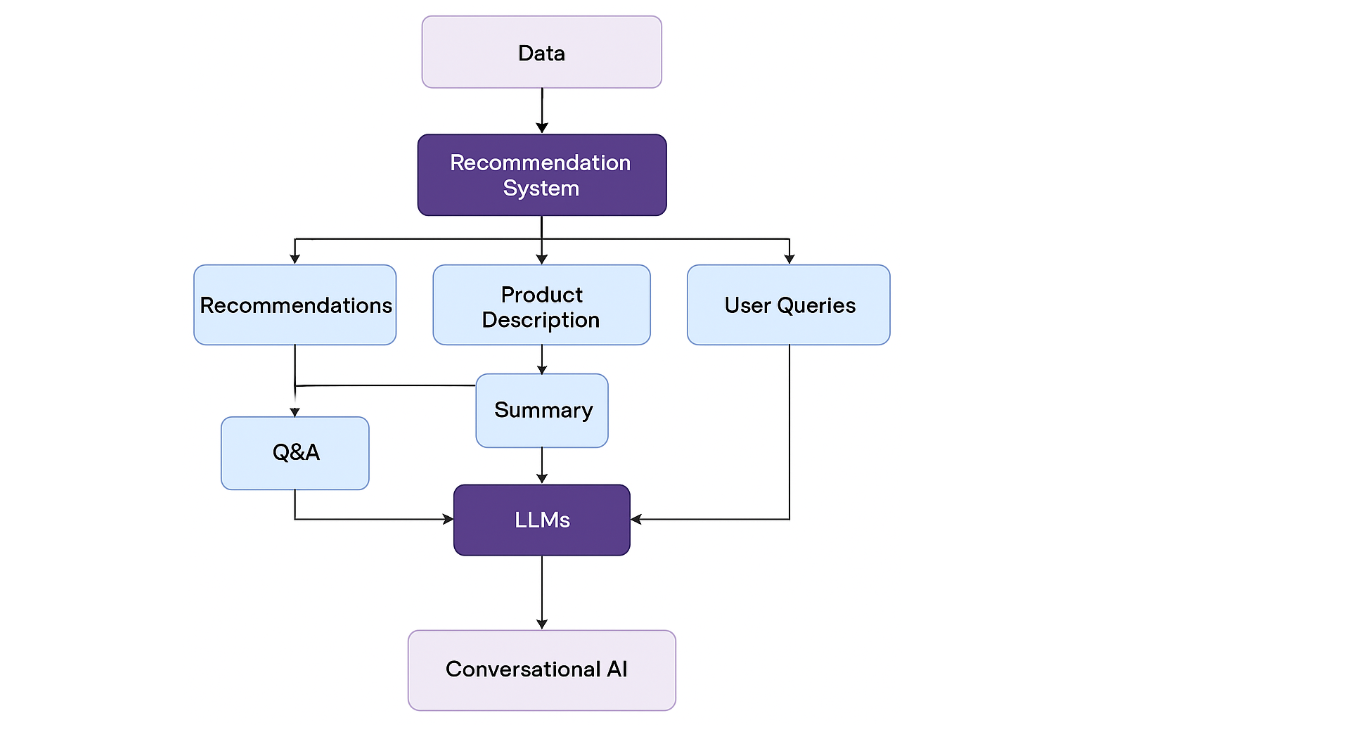

# Install dependencies and Load the Data


In [1]:
!pip install kaggle
!pip install xlsxwriter
!pip install transformers
!pip install datasets
!pip install transformers[sentencepiece] datasets
!pip install sentencepiece
# !pip install openai
!pip install transformers torch accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 8.9 MB/s eta 0:00:00


In [3]:
# Load the dataset

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -l ~/.kaggle
!kaggle datasets download -d karkavelrajaj/amazon-sales-dataset

#import zipfile module
from zipfile import ZipFile

with ZipFile('amazon-sales-dataset.zip', 'r') as f:
  f.extractall()

total 4
-rw------- 1 root root 74 Oct 29 19:29 kaggle.json
Dataset URL: https://www.kaggle.com/datasets/karkavelrajaj/amazon-sales-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/1.95M [00:00<?, ?B/s]
100% 1.95M/1.95M [00:00<00:00, 1.02GB/s]


In [4]:
##Import Libraries

#Basic Libraries
import os
import numpy as np
import pandas as pd
#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Text Handling Libraries
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import xlsxwriter
import scipy.spatial
import datetime
from datasets import load_dataset
from transformers import pipeline
from tqdm import tqdm
import datetime


In [15]:
## Load Data
df = pd.read_csv("amazon.csv")

# EDA of Data , Data Preparation and Cleaning

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [16]:
df.isnull().sum()

,0
product_id,0
product_name,0
category,0
discounted_price,0
actual_price,0
discount_percentage,0
rating,0
rating_count,2
about_product,0
user_id,0


Dataset Info: 1,465 entries, 16 columns including product details, prices, ratings, and reviews.

Missing Values: Only rating_count has 2 missing entries; others are complete.

Data Types: Numeric columns (discounted_price, actual_price, discount_percentage, rating, rating_count) are stored as objects and need conversion.

Next Steps: Clean numeric columns, convert types, handle missing rating_count values.

In [17]:
# Convert to string first, then remove ₹ and commas
df['discounted_price'] = df['discounted_price'].astype(str).str.replace('₹', '').str.replace(',', '')
df['actual_price'] = df['actual_price'].astype(str).str.replace('₹', '').str.replace(',', '')

# Convert to float safely
df['discounted_price'] = pd.to_numeric(df['discounted_price'], errors='coerce')
df['actual_price'] = pd.to_numeric(df['actual_price'], errors='coerce')

# Remove % from discount and convert to float
df['discount_percentage'] = df['discount_percentage'].astype(str).str.replace('%', '')
df['discount_percentage'] = pd.to_numeric(df['discount_percentage'], errors='coerce')

# Convert rating to float safely
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Remove commas from rating_count and convert to int safely
df['rating_count'] = df['rating_count'].astype(str).str.replace(',', '')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

In [18]:
# Fill missing numeric values with median
df['rating'].fillna(df['rating'].median(), inplace=True)
df['rating_count'].fillna(df['rating_count'].median(), inplace=True)

#  Verify changes
df.info()
df.head()

/tmp/ipython-input-1363253813.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating'].fillna(df['rating'].median(), inplace=True)
/tmp/ipython-input-1363253813.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1465 non-null   object 
 1   product_name         1465 non-null   object 
 2   category             1465 non-null   object 
 3   discounted_price     1465 non-null   float64
 4   actual_price         1465 non-null   float64
 5   discount_percentage  1465 non-null   int64  
 6   rating               1465 non-null   float64
 7   rating_count         1465 non-null   float64
 8   about_product        1465 non-null   object 
 9   user_id              1465 non-null   object 
 10  user_name            1465 non-null   object 
 11  review_id            1465 non-null   object 
 12  review_title         1465 non-null   object 
 13  review_content       1465 non-null   object 
 14  img_link             1465 non-null   object 
 15  product_link         1465 non-null   o

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43,4.0,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [19]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
df.describe()

Number of duplicate rows: 0


,discounted_price,actual_price,discount_percentage,rating,rating_count
count,1465.000000,1465.000000,1465.000000,1465.000000,1465.000000
mean,3125.310874,5444.990635,47.691468,4.096587,18277.634812
std,6944.304394,10874.826864,21.635905,0.291574,42727.398216
min,39.000000,39.000000,0.000000,2.000000,2.000000
25%,325.000000,800.000000,32.000000,4.000000,1191.000000
50%,799.000000,1650.000000,50.000000,4.100000,5179.000000
75%,1999.000000,4295.000000,63.000000,4.300000,17325.000000
max,77990.000000,139900.000000,94.000000,5.000000,426973.000000


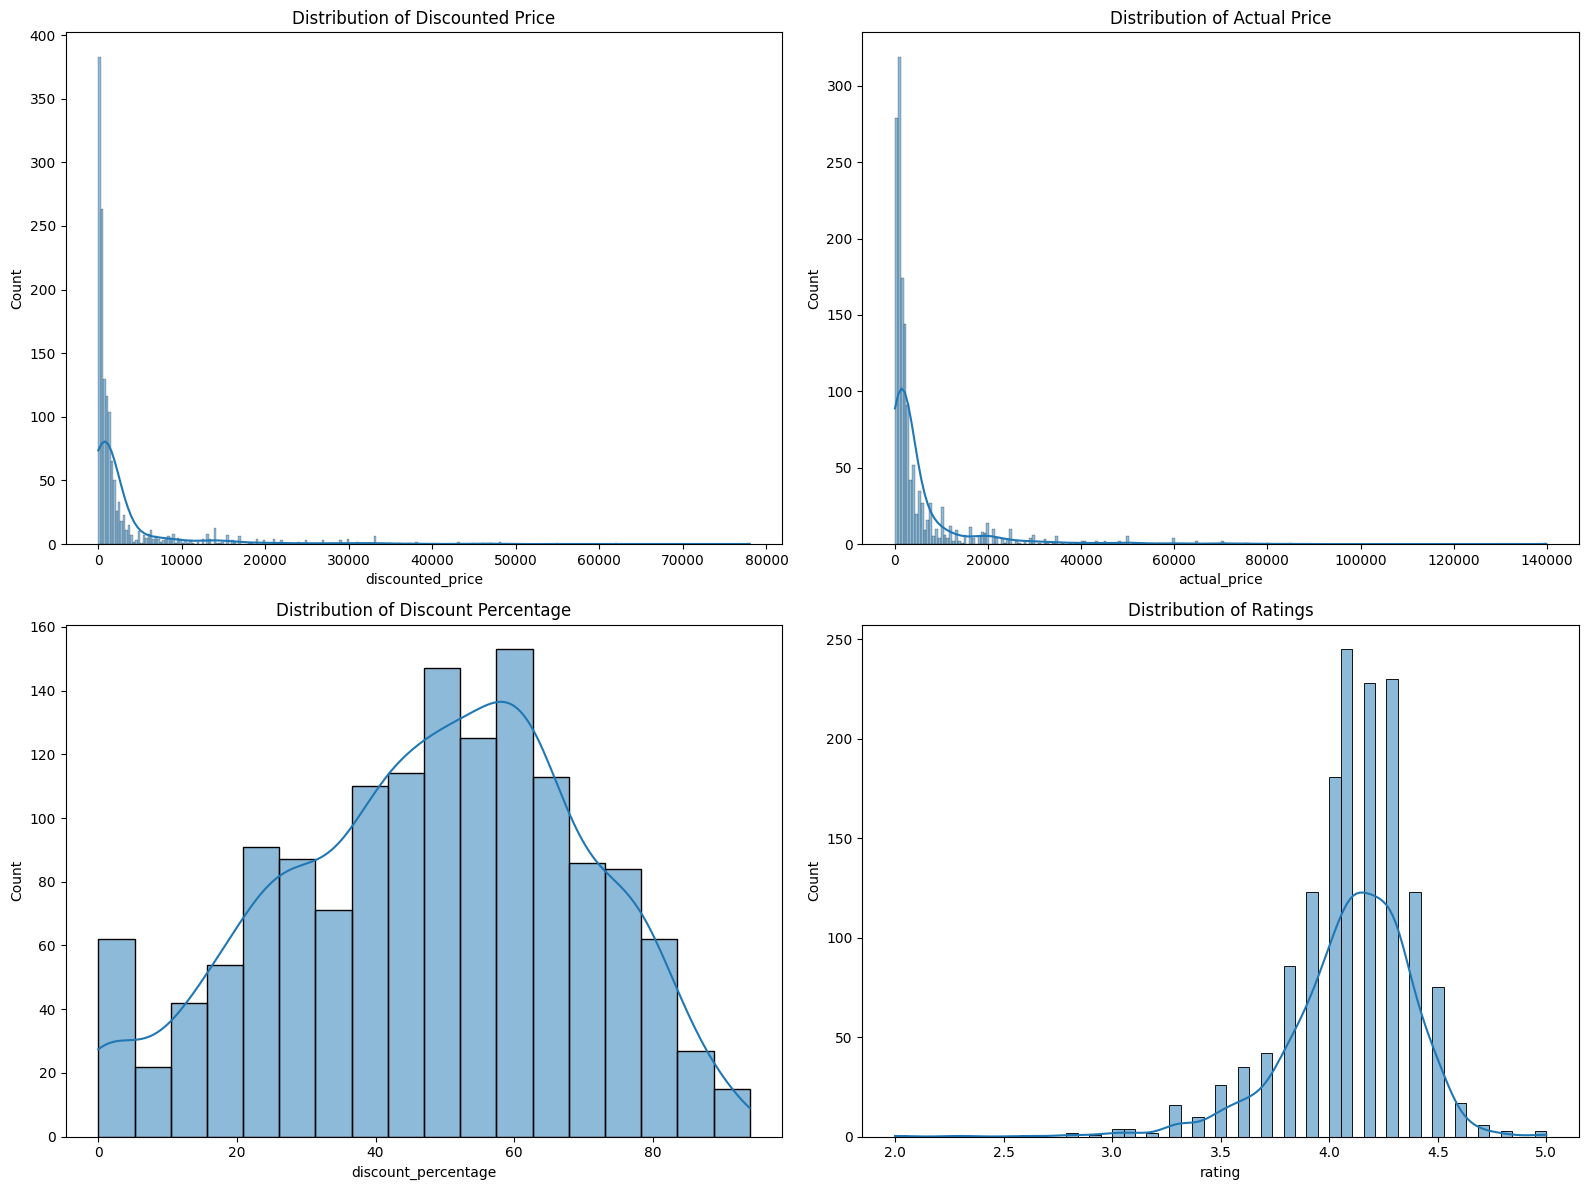

In [20]:
#Distribution of Numerical Features

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(df['discounted_price'], kde=True, ax=axes[0,0])
axes[0,0].set_title("Distribution of Discounted Price")

sns.histplot(df['actual_price'], kde=True, ax=axes[0,1])
axes[0,1].set_title("Distribution of Actual Price")

sns.histplot(df['discount_percentage'], kde=True, ax=axes[1,0])
axes[1,0].set_title("Distribution of Discount Percentage")

sns.histplot(df['rating'], kde=True, ax=axes[1,1])
axes[1,1].set_title("Distribution of Ratings")

plt.tight_layout()
plt.show()

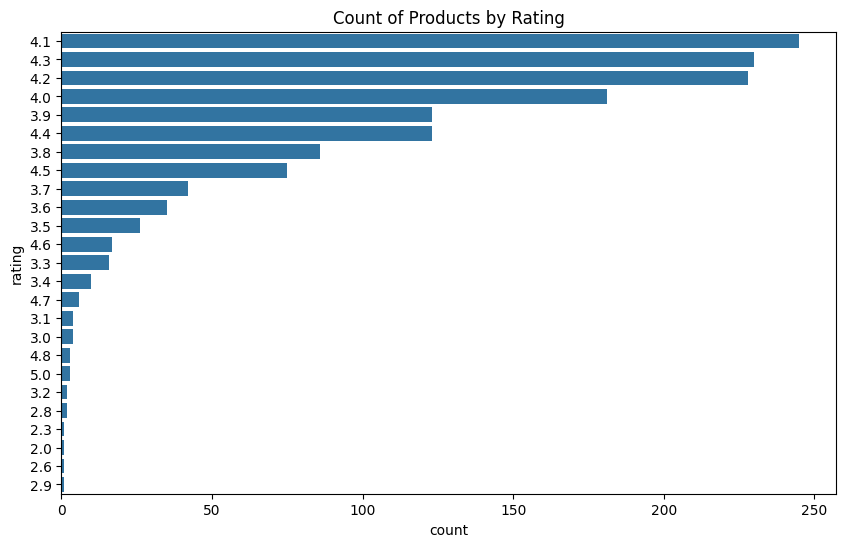

In [21]:
#Count of Products by Rating

plt.figure(figsize=(10,6))
sns.countplot(y=df['rating'], order=df['rating'].value_counts().index)
plt.title("Count of Products by Rating")
plt.show()


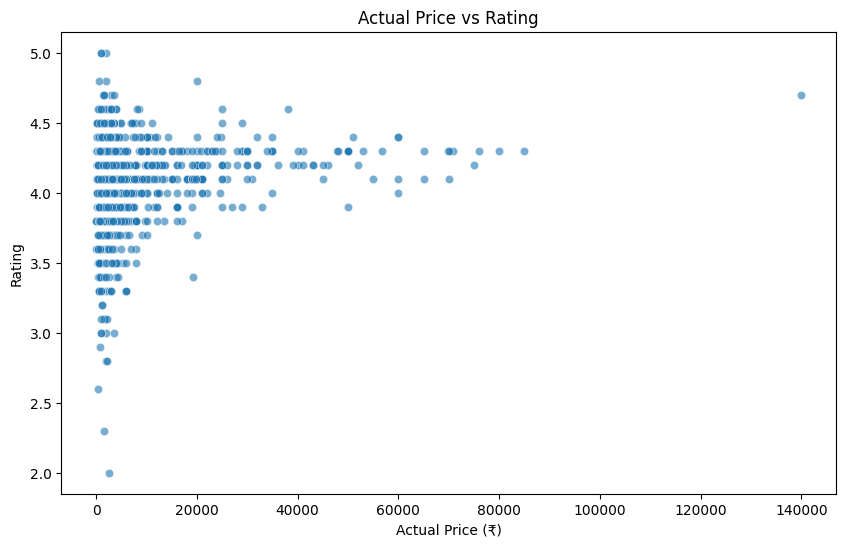

In [22]:
#Price vs Rating

plt.figure(figsize=(10,6))
sns.scatterplot(x="actual_price", y="rating", data=df, alpha=0.6)
plt.title("Actual Price vs Rating")
plt.xlabel("Actual Price (₹)")
plt.ylabel("Rating")
plt.show()

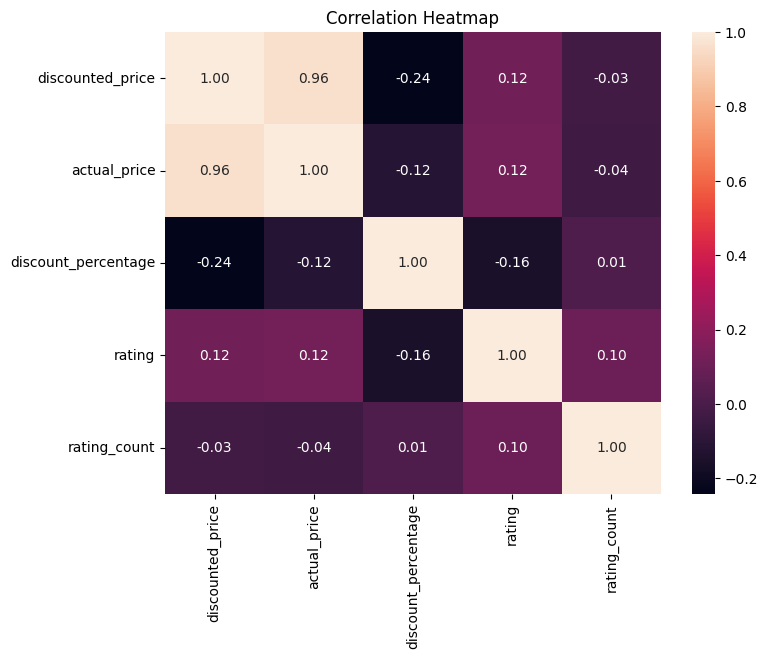

In [23]:
#Correlation Heatmap

plt.figure(figsize=(8,6))
corr = df[['discounted_price','actual_price','discount_percentage','rating','rating_count']].corr()
sns.heatmap(corr, annot=True,  fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

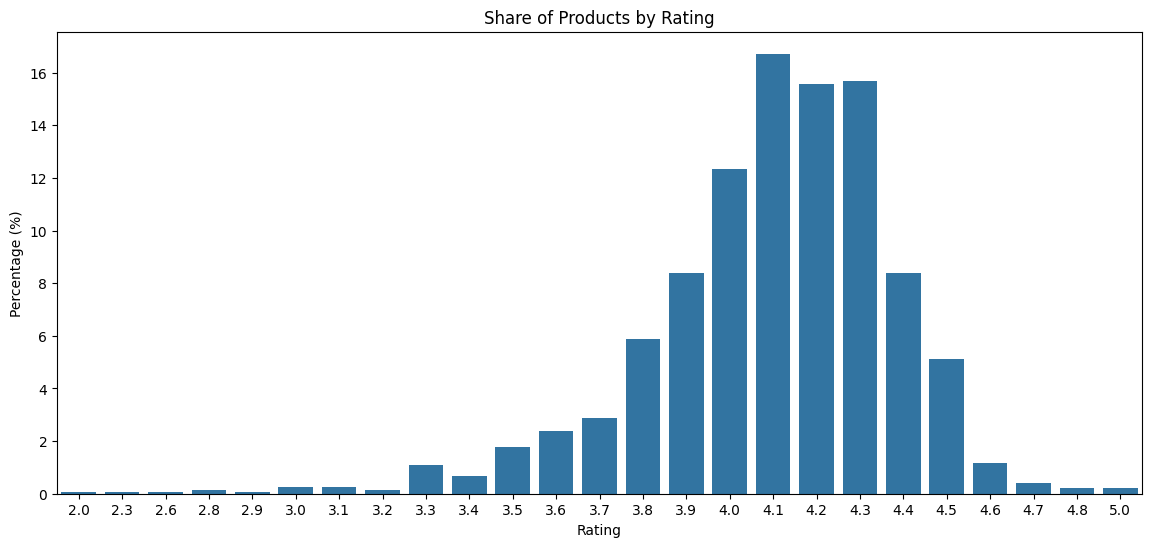

In [24]:
# Share of Products by Rating (%)

plt.figure(figsize=(14,6))
rating_counts = df['rating'].value_counts(normalize=True) * 100
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.ylabel("Percentage (%)")
plt.xlabel("Rating")
plt.title("Share of Products by Rating")
plt.show()

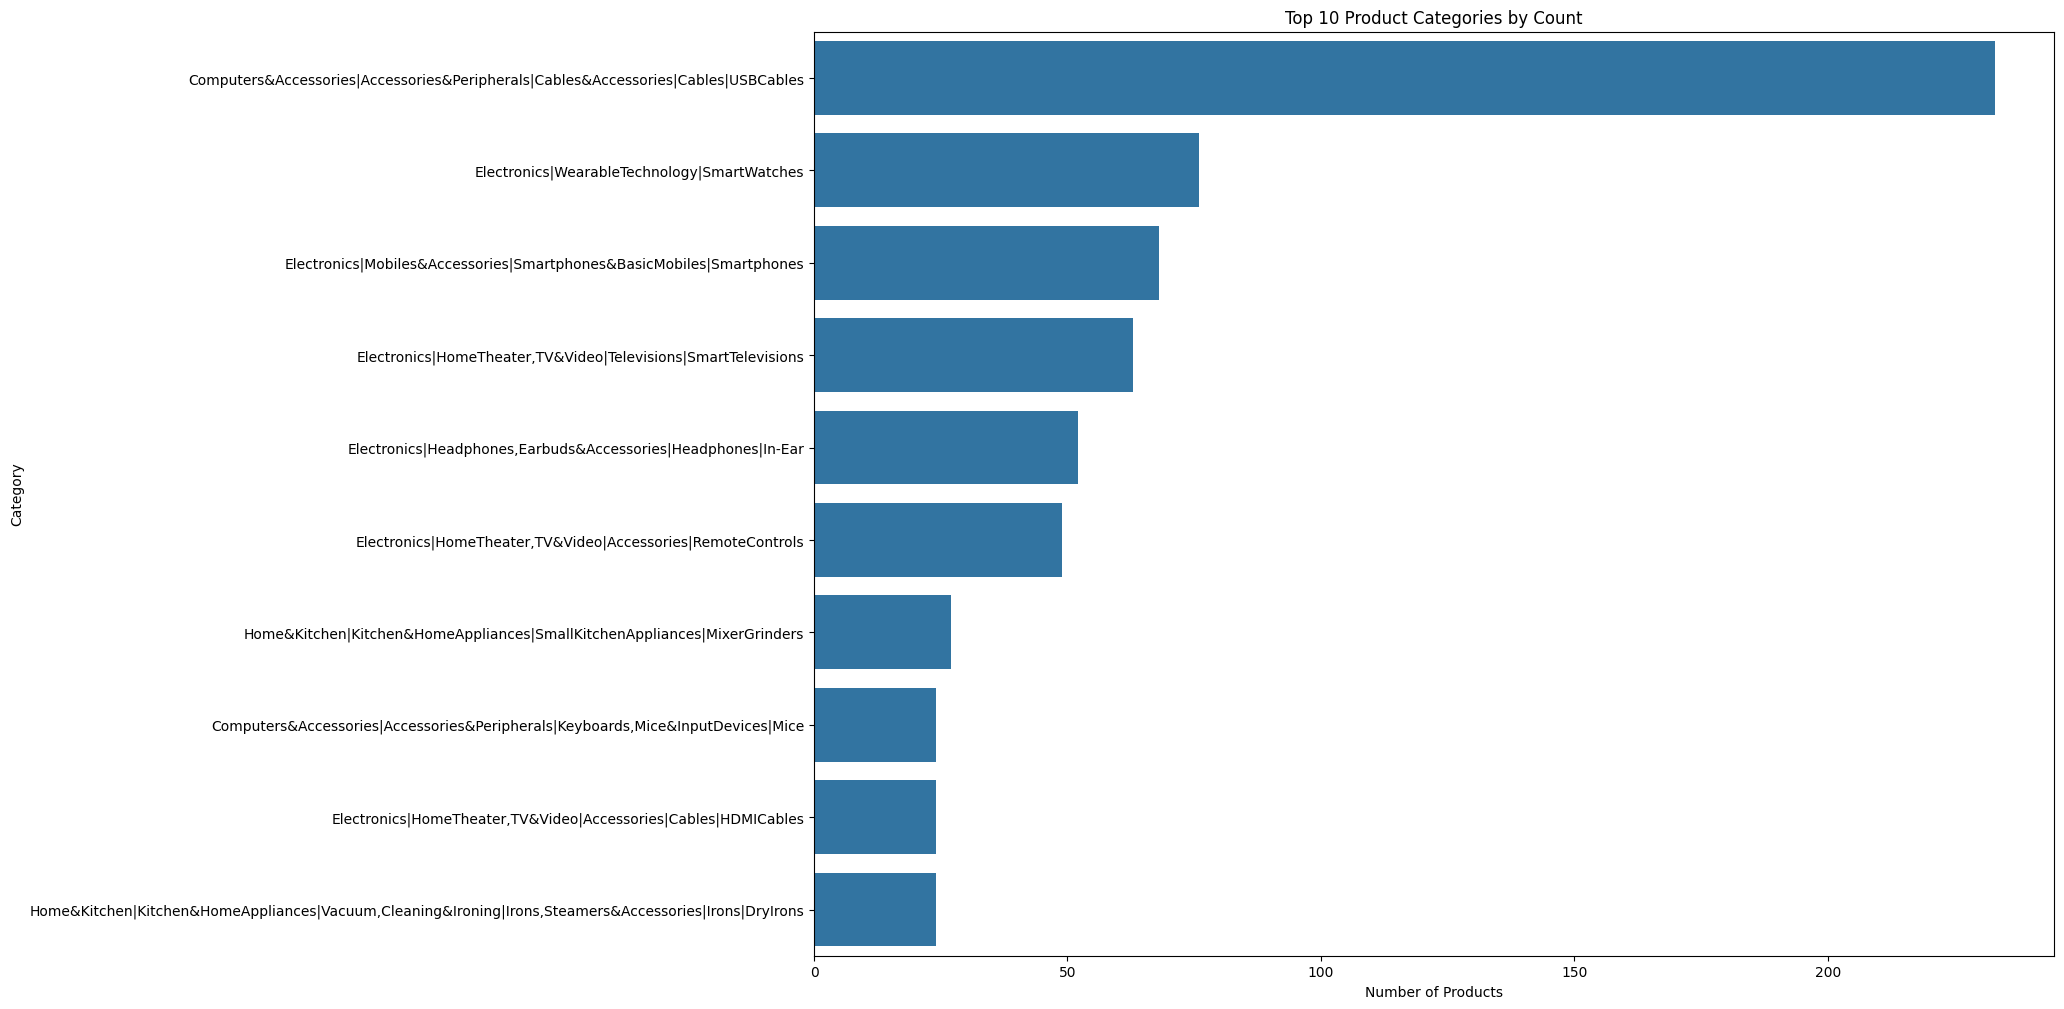

In [25]:
#Top 10 Product Categories

plt.figure(figsize=(16,12))
top_categories = df['category'].value_counts().nlargest(10)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 10 Product Categories by Count")
plt.xlabel("Number of Products")
plt.ylabel("Category")
plt.show()

**Observations from Visualizations**

- Price Distribution (Discounted & Actual)
    Both price variables show a right-skewed distribution.
    The majority of products are in the low to mid-price range.
    High-end items are uncommon, indicating only a few premium listings.
 - Discount Percentage
    Discount percentages vary, but most fall between 40% and 70%.
    This suggests Amazon frequently offers large discounts to attract buyers.
  - Rating Distribution
    Most ratings are between 3.5 and 4.5 stars, with a visible peak near 4.0.
    Reflects high customer satisfaction and good product quality.
    Only a small number of products have ratings below 3.
  - Share of Products by Rating
    Nearly 95% of products hold ratings around 4 stars or above.
    Indicates that the dataset is dominated by positive reviews.
  - Count of Products by Exact Rating
    The most frequent ratings are 4.0, 4.1, 4.2, and 4.3.
    Few products have neutral or low ratings, showing strong seller reputation and customer trust.

In [26]:
df.drop('rating_count',axis=1,inplace=True)

#Renaming for convinience
df.rename(columns={' product_id ':'ProdId','product_name':'ProdName','discounted_price':'DPrice','actual_price':'APrice',
                  'discount_percentage':'DPerct','about_product':'ProdDescr','user_id':'UID','user_name':'UName',
                  'product_link' :'ProdLink',
                  },
          inplace=True)

In [11]:
df2 = df.copy(deep=True)

# Feature Engineering

In [27]:
# Extract the last subcategory from the 'category' column efficiently
df2['Subcategory'] = (
    df2['category']
    .astype(str)                 # ensure it's string
    .str.split('|')              # split by '|'
    .str[-1]                     # take the last part
    .str.strip()                 # remove any extra spaces
)


In [28]:
(df2.rating.value_counts())

,count
rating,
4.1,244
4.3,230
4.2,228
4.0,129
3.9,123
4.4,123
3.8,86
4.5,75
4,52


In [29]:
#Replace with subcategory mean
df2['rating'] = pd.to_numeric(df2['rating'], errors='coerce')
df2['rating'] = df2.groupby('Subcategory')['rating'].transform(
    lambda x: x.fillna(x.mean())
)
df2.rating = df2.rating.astype(float)

In [30]:
# #Filter out records with less than 8 records
n = 8
df2=df2.groupby("Subcategory").filter(lambda x: len(x) >= n )

In [31]:
#Upsample Df

from sklearn.utils import resample

# Count items per subcategory
catgr_counts = df2['Subcategory'].value_counts()

# Find the target count (largest category to match)
target_count = catgr_counts.max()  # instead of hardcoding 'RemoteControls'

# Upsample underrepresented subcategories
for index, (item, count) in enumerate(catgr_counts.items()):
    item_df = df2[df2['Subcategory'] == item]

    if count < target_count:
        df_upsample = resample(
            item_df,
            replace=True,             # sample with replacement
            n_samples=target_count,   # match majority class size
            random_state=42
        )
        df2 = pd.concat([df2, df_upsample], axis=0)

df2.reset_index(drop=True, inplace=True)


In [32]:
#Creating a derived feature for Rating Bucket - Low, Medium,High .

col = 'rating'
df2[col]=df2[col].astype(float)
conditions = [
              df2[col].between(0,3),   #CheapPrice  # inclusive = True is the default
              df2[col].between(3,4),  #LowPrice
              df2[col].ge(4) #LittleAboveLowPrice

             ]
choices = ["LR","MR","HR"]

df2['rBucket'] = np.select(conditions, choices, default='nan')
df2['rBucket'].unique()

array(['HR', 'MR', 'LR'], dtype=object)

In [ ]:
df2['rBucket'].value_counts()

HR    2651
MR    1502
LR      49
Name: rBucket, dtype: int64

In [33]:
#Creating a derived feature for Rating Bucket - Low, Medium,High .

col = 'DPrice'
conditions = [
              df2[col].between(0,500),   #CheapPrice  # inclusive = True is the default
              df2[col].between(500,1000),  #LowPrice
              df2[col].ge(1000) #LittleAboveLowPrice

             ]
choices = ["Low","Medium","High"]

df2['DPBucket'] = np.select(conditions, choices, default='nan')
df2['DPBucket'].unique()

array(['Low', 'High', 'Medium'], dtype=object)

In [34]:
##Creating a derived feature to classify product based on discount offered , ratings for each subcateogry under each product

def couple(x):
    return ''.join(x['product_id']) + ' '+ ''.join(x['DPBucket'])+ ' '+ ''.join(x['rBucket']) + ' '+ ''.join(x['Subcategory'])

df2['product_classification_features'] = df2.apply(couple, axis=1)

# Computing Product Similarities

In [35]:
# Let’s calculate the cosine similarity of the product_classification_features for all the products.We create a count matrix for number of products,number of features

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['product_classification_features'])


In [36]:
#We compute cosine similarity for each product . Directly N X N wil be huge so we compoute in manageable chunks

# Define batch size , 500 product each time
batch_size = 500

# Calculate number of batches
num_batches = int(count_matrix.shape[0] / batch_size)

# Initialize an empty array for results, later it will store similarity between products i,j at i th row and j th column
cosine_sim = np.zeros((count_matrix.shape[0], count_matrix.shape[0]))

# Calculate cosine similarity in batches
for i in range(num_batches):
    start = i * batch_size
    end = (i + 1) * batch_size
    #// computing simlartiy between products at start:end with all other products in set
    cosine_sim[start:end] = cosine_similarity(count_matrix[start:end], count_matrix)
    # print(cosine_sim.shape)

In [37]:
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df.shape

(11580, 11580)

In [38]:
#given the title we find out , the most similar products to the title . ex : Headphone then we suggest , airpods , earphone etc ..

def content_recommendation_v1(title):
    """
    Generate top-N content-based product recommendations for a given product ID.

    This function uses the cosine similarity matrix (cosine_sim_df) computed from
    product features (such as price bucket, rating bucket, subcategory, etc.)
    to find products that are most similar to the given 'title' (product_id).

    Parameters
    ----------
    title : str
        The product_id of the item for which similar products are to be recommended.
    n : int, optional (default=10)
        The number of similar products to return.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the top-N most similar product IDs and their
        cosine similarity scores, sorted by similarity in descending order.
    """
    a = df2.copy(deep=True).reset_index().drop('index',axis=1)
    index = a[a['product_id']==title].index[0]
    top_n_index = list(cosine_sim_df[index].nlargest(11).index)
    try:
        top_n_index.remove(index)
    except:
        pass
    similar_df = a.iloc[top_n_index][['product_id']]
    similar_df['cosine_similarity'] = cosine_sim_df[index].iloc[top_n_index]
    return similar_df


In [ ]:
cosine_sim_df.shape

(4202, 4202)

In [39]:
#We build product to product recommendation table ex : For product A , we have products B,C,D similar to it .
# ------------------------------------------------------------------------------
# Build the Product-to-Product Recommendation Table (df3)
#
# For each unique product in the dataset:
#   1. Retrieve its details (subcategory, name, etc.).
#   2. Use the content_recommendation_v1() function to find the top-N most
#      similar products based on cosine similarity of product features.
#   3. Merge the recommended product IDs with their corresponding metadata
#      (subcategory, product name) for clarity.
#   4. Combine the searched product and its recommended products into a
#      single DataFrame (tmpDf), and append to the master table df3.
#
# The final df3 DataFrame contains a structured mapping:
#     searched product  →  recommended products + similarity scores
#
# This dataset can later be exported or queried to display
# "Customers also viewed" or "Similar items" style recommendations.
# ------------------------------------------------------------------------------

df3=pd.DataFrame()
uniqueProds=list(df2['product_id'].unique())
for prodID in uniqueProds:
    try:
        searchedProd=df2[df2['product_id']==prodID][['Subcategory','product_id','ProdName']].drop_duplicates().reset_index(drop=True).rename(columns={'product_id':'searchedProd'})
        # print("searchedProd :",prodID, "searchedProd shape :",searchedProd.shape)
        suggestedProdIDs=content_recommendation_v1(prodID)
        ProdsID=list(suggestedProdIDs['product_id'])
        # print("SuggestedProds length:",len(set(suggestedProdIDs['product_id'])))
        suggestedProds= pd.merge(suggestedProdIDs,df2[df2['product_id'].isin(ProdsID)][['product_id','Subcategory','ProdName']].drop_duplicates(),on='product_id',how='inner')
        # print("testing")
        suggestedProds=suggestedProds.rename(columns={'cosine_similarity':'Similarity_Score','product_id':'SuggProd_Id','ProdName':'SuggProdNames'})
        # print("suggestedProds shape :",suggestedProds.shape)

        tmpDf=pd.concat([searchedProd,suggestedProds],axis=1).drop_duplicates(subset='SuggProd_Id').reset_index(drop=True)
#         print("tmpDf :",tmpDf)
        # print("tmpDf shape :",tmpDf.shape)
        df3=pd.concat([tmpDf,df3],axis=0)
        # print("df3 shape :",df3.shape)
    except:
        print("Error in prodID :",prodID)
        pass


# Performing Users Clustering

In [40]:
###################################################################### Users Clustering #############################################3
# Preparing Data for User based Collaborative filtering , It converts product-centric data (each product with multiple users) → into a user-centric table (each user’s individual product ratings).
# ------------------------------------------------------------------------------
# Build the User–Product Interaction Table (newDf)
#
# Objective:
#     Transform the product-level dataset (df2), where each product may have
#     multiple user IDs stored as a comma-separated string, into a normalized
#     user–product format suitable for collaborative filtering.
#
# Process:
#     1. Initialize an empty DataFrame (newDf) with columns for User ID, Product ID,
#        Subcategory, Product Name, and Rating.
#     2. For each product in df2:
#           - Split the 'UID' string into individual user IDs.
#           - Create a small DataFrame mapping each user to that product and its rating.
#           - Concatenate these mini tables into newDf.
#
# Result:
#     The resulting newDf represents a flattened view of all user–product interactions,
#     where each row corresponds to one (user, product, rating) relationship.
#
# Example Output:
#     UID        ProdId       Subcategory     ProdName             rating
#     --------------------------------------------------------------------
#     UXXX       PXXX         Headphones      Sony                 4.8
#
# This structure is essential for the next step — creating a user-item matrix
# and performing user-based collaborative filtering or clustering.
# ------------------------------------------------------------------------------

newDf= pd.DataFrame(columns= ['UID',"ProdId","Subcategory","rating"])
for index, row in df2.iterrows():
  # print("usr :", type(row['UID']))
  usrs=row['UID'].split(",")
  tmpDf = pd.DataFrame({'UID': usrs,"ProdId":row['product_id'],"Subcategory": row["Subcategory"],"ProdName":row["ProdName"],'rating':row['rating']})
  newDf= pd.concat([newDf,tmpDf],axis=0,ignore_index = True)
  # print("df2 shape :",df2.shape)

newDf.head()

/tmp/ipython-input-4133256917.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newDf= pd.concat([newDf,tmpDf],axis=0,ignore_index = True)


,UID,ProdId,Subcategory,rating,ProdName
0,AG3D6O4STAQKAY2UVGEUV46KN35Q,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...
1,AHMY5CWJMMK5BJRBBSNLYT3ONILA,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...
2,AHCTC6ULH4XB6YHDY6PCH2R772LQ,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...
3,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...
4,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,B07JW9H4J1,USBCables,4.2,Wayona Nylon Braided USB to Lightning Fast Cha...


In [41]:
# # ------------------------------------------------------------------------------
# Create the User–Item Rating Matrix (user_item_matrix)
#
# Objective:
#     Transform the long-form user–product rating data (newDf) into a structured
#     matrix format suitable for collaborative filtering.
#
# Process:
#     - Each row represents a unique user (UID).
#     - Each column represents a unique product (ProdId).
#     - Each cell contains the average rating that user has given to that product.
#     - Missing ratings (no user–product interaction) are filled with 0 to indicate
#       absence of a rating and to maintain a fully numeric matrix.
#
# Why:
#     This matrix serves as the foundation for user-based collaborative filtering.
#     Once created, we can compute pairwise similarities between users based on
#     their product rating patterns (using cosine, Jaccard, or Pearson distance).
#
# Example:
#     Input (newDf):
#         UID    ProdId    rating
#         -----------------------
#         U1     P1        4.5
#
#     Output (user_item_matrix):
#             P1    P2    P3    P4
#         --------------------------
#         U1   4.5   0.0   3.0   0.0
#
# This transformation converts the data into a machine-readable format
# that allows clustering users or finding similar profiles for personalized
# product recommendations.
# ------------------------------------------------------------------------------

user_item_matrix = pd.pivot_table(
    newDf,
    index='UID',
    columns='ProdId',
    values='rating',
    aggfunc='mean',
    fill_value=0
)

# user_item_matrix.columns=user_item_matrix.columns.droplevel(0)
user_item_matrix.fillna(0, inplace=True)
user_item_matrix.head()

ProdId,B002PD61Y4,B002SZEOLG,B003L62T7W,B004IO5BMQ,B005FYNT3G,B0085IATT6,B0085W2MUQ,B0088TKTY2,B008FWZGSG,B008IFXQFU,...,B0BP18W8TM,B0BP7XLX48,B0BP89YBC1,B0BPBG712X,B0BPBXNQQT,B0BPCJM7TB,B0BPJBTB3F,B0BQ3K23Y1,B0BQRJ3C47,B0BR4F878Q
UID,,,,,,,,,,,,,,,,,,,,,
AE22E2AXODSPNK3EBIHNGYS5LOSA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE23RS3W7GZO7LHYKJU6KSKVM4MQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE242TR3GQ6TYC6W4SJ5UYYKBTYQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE24UFIVBSESSEV7UALTKP7K5Z4A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# ------------------------------------------------------------------------------
# Compute User–User Jaccard Distance Matrix
#
# Objective:
#     Quantify how similar or dissimilar each pair of users is, based on their
#     product interaction patterns from the user–item matrix.
#
# Process:
#     - Each row and column in 'user_item_matrix' represents a unique user (UID).
#     - Each cell value represents whether a user has interacted with a product
#       (non-zero rating) or not (zero).
#     - Using scipy's cdist() with metric='jaccard', we compute the Jaccard
#       distance between every pair of users:
#
#           Jaccard Distance = 1 - ( |A ∩ B| / |A ∪ B| )
#
#       where A and B are the sets of products interacted with by two users.
#
# Result:
#     'user_distance' is a square DataFrame where:
#         - Rows and columns are user IDs (UIDs)
#         - Each cell (i, j) contains the Jaccard distance between user i and j
#           (0 = identical preferences, 1 = no overlap)
#
# Example:
#     Input user_item_matrix:
#           P1  P2  P3  P4
#       U1  1   0   1   0
#
#     Output user_distance:
#           U1   U2   U3
#       U1  0.00 1.00 0.25
#
# This matrix provides the foundation for user clustering or finding the most
# similar users to generate personalized, collaborative recommendations.
# ------------------------------------------------------------------------------


jaccard = scipy.spatial.distance.cdist(user_item_matrix, user_item_matrix,
                                       metric='jaccard')
user_distance = pd.DataFrame(jaccard, columns=user_item_matrix.index.values,
                             index=user_item_matrix.index.values)

In [36]:
user_distance.head()

,AE22E2AXODSPNK3EBIHNGYS5LOSA,AE22MK2NXQD3ZARLIOL3SLD4GU6A,AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,AE23RS3W7GZO7LHYKJU6KSKVM4MQ,AE23WGYTUMB5R6JJMBU4V43JIW7Q,AE242TR3GQ6TYC6W4SJ5UYYKBTYQ,AE24UFIVBSESSEV7UALTKP7K5Z4A,AE26ZTVZB6CB4VML6JSTYTL2QG6A,AE27QPJRG7545VJX7LYRK2EO3I4Q,AE27UOZENYSWCQVQRRUQIV2ZM7VA,...,AHZRZRBWNNDHG2KXXLPRZVBTHTUQ,AHZS47WK6D5XJ6FS6DINGACMRQKQ,AHZSWCFTWESY2N2RK4BVWBMM4TZQ,AHZTLZNYRSIEOCNNYMQCXWTWA62Q,AHZWJCVEIEI76H2VGMUSN5D735IQ,AHZWXUWE3RGLDH4JJUK3HT3VMBJA,AHZXKAGAJPIMZJD5XJ5QUIYR3ORA,AHZYN7O73FJWRPUQGZM5BEAZ3A4A,AHZZFBL24XXVLW6H44MOB6LBHH5A,AHZZXJWETMZR7SH7C22KVUT7VHAA
AE22E2AXODSPNK3EBIHNGYS5LOSA,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE22MK2NXQD3ZARLIOL3SLD4GU6A,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE22Y3KIS7SE6LI3HE2VS6WWPU4Q,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE23RS3W7GZO7LHYKJU6KSKVM4MQ,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AE23WGYTUMB5R6JJMBU4V43JIW7Q,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [43]:
# ------------------------------------------------------------------------------
# Build the User Similarity Ranking Dictionary (user_rankings)
#
# Objective:
#     For each user, create an ordered list of the most similar users based on
#     the pairwise Jaccard distance values computed earlier.
#
# Process:
#     1. Loop through each user (column) in the user_distance DataFrame.
#     2. For the current user:
#           - Retrieve the entire column of distances to all other users.
#           - Sort the distances in ascending order (lower distance = higher similarity).
#           - Exclude the user itself (distance = 0).
#     3. Store this ordered list of similar users in a dictionary where:
#           key   = user ID (UID)
#           value = list of other users ranked from most to least similar.
#
# Result:
#     The 'user_rankings' dictionary provides a fast lookup of each user's
#     nearest neighbors. This structure is essential for collaborative filtering,
#     allowing recommendations to be generated based on similar users' preferences.
#
# Example:
#     Given a small user_distance matrix:
#           U1    U2    U3    U4
#       U1  0.00  1.00  0.25  0.50
#
#     The resulting dictionary would be:
#         {
#             'U1': ['U3', 'U4', 'U2'],
#         }
#
#     This mapping defines each user's most similar neighbors and serves as the
#     basis for personalized recommendations in the collaborative filtering step.
# ------------------------------------------------------------------------------

user_rankings = {}
# iterate over the columns in the dataframe
for user in user_distance.columns:
    # extract the distances of the column ranked by smallest
    distance = user_distance[user].nsmallest(len(user_distance))

    # for each user, create a key in the dictionary and assign a
    # list that contains a ranking of its most similar users
    data = {user : [i for i in distance.index if i!=user]}
    user_rankings.update(data)

In [38]:
user_rankings['AE22MK2NXQD3ZARLIOL3SLD4GU6A'][0:10] #10 most similar users

['AHAHSX35S3ZUCKX2UAB3DPGWCYJA',
 'AG2GXBIXLFJD652RYILCZS44PBAA',
 'AFV75LSQUFRY327UWQEBYQKLFSMA',
 'AEZSW3HIRJ2OUNDQHDJEB7NMGUWQ',
 'AEUFMJPVYKUAB34FPZ53O2EE7VNQ',
 'AEPZDUAEBII7N7RRWKTPKON6HB3A',
 'AECUHYUPESWI2DB5JMEZQF77VWOA',
 'AHZYN7O73FJWRPUQGZM5BEAZ3A4A',
 'AHZXKAGAJPIMZJD5XJ5QUIYR3ORA',
 'AHZWXUWE3RGLDH4JJUK3HT3VMBJA']

In [44]:
# ------------------------------------------------------------------------------
# Build the User–User Product Interaction Mapping (df4)
#
# Objective:
#     Generate a combined view that links each user with their top-N most similar
#     users (from user_rankings) and captures the products those similar users
#     have interacted with. This serves as the foundation for user-based
#     collaborative filtering recommendations.
#
# Process:
#     1. Record the start time to measure processing duration.
#     2. Initialize an empty DataFrame (df4) to accumulate results.
#     3. Iterate through the user_rankings dictionary:
#           - For the current user (UID), extract all products they have rated
#             from newDf (user–product table).
#           - Select the top-N most similar users (here, top 10).
#           - Retrieve those similar users' product interactions from newDf.
#           - Concatenate the searched user's products and the similar users'
#             products side by side to form a combined mapping.
#           - Append this temporary result to the master DataFrame (df4).
#     4. Use try/except to skip any problematic user entries without halting execution.
#     5. Capture the end time and compute total processing time in seconds.
#
# Result:
#     The resulting DataFrame (df4) maps each user to their most similar users
#     and the corresponding products those users have interacted with.
#
# Example Output:
#     UID   ProdId   ProdName          rating   SimilarUsers   ProdId   ProdName              rating
#     -----------------------------------------------------------------------------------------------
#     U1    P1       Sony WH-1000XM4   4.8      U3             P2       Bose QC45             4.6
#
#     This structure enables recommending products to a target user
#     based on what their most similar users have purchased or rated highly.
# ------------------------------------------------------------------------------


start_time = datetime.datetime.now()

df4=pd.DataFrame()

for index, (UID,simUsr) in enumerate(user_rankings.items()):
    try:
        searchedUID=newDf[newDf['UID']==UID][['UID','ProdId','Subcategory','ProdName','rating']].drop_duplicates().reset_index(drop=True)
        # print("searchedUID :",UID, "searchedUID shape :",searchedUID.shape)
        # print("searchedUID['Subcategory'].unique() :",searchedUID['Subcategory'].unique())

        # top 10 neighbours for each user

        sim_usrs_n=simUsr[0:10] #10 most similar users
        sim_usrs_df=newDf[newDf['UID'].isin(sim_usrs_n)].rename(columns={'UID':'SimilarUsers'}).reset_index(drop=True)

        tmpDf=pd.concat([searchedUID,sim_usrs_df],axis=1)
        # print("tmpDf :",tmpDf)
        # print("tmpDf shape :",tmpDf.shape)
        df4=pd.concat([tmpDf,df4],axis=0)
        # print("df3 shape :",newDf.shape)
    except:
        # print("Except triggered")
        print("Error in UID :",UID)
        pass


end_time = datetime.datetime.now()

# Calculate the time difference in seconds
time_difference = (end_time - start_time).total_seconds()

print("The time difference is:", round(time_difference,2))


The time difference is: 261.74


In [40]:
df3.head()

,Subcategory,searchedProd,ProdName,SuggProd_Id,Similarity_Score,Subcategory,SuggProdNames
0,SandwichMakers,B01486F4G6,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,B07S851WX5,0.75,SandwichMakers,"Prestige Sandwich Maker PGMFD 01, Black"
1,NaN,NaN,NaN,B0B6F7LX4C,0.50,SmartTelevisions,MI 80 cm (32 inches) 5A Series HD Ready Smart ...
2,NaN,NaN,NaN,B08DPLCM6T,0.50,SmartTelevisions,LG 80 cm (32 inches) HD Ready Smart LED TV 32L...
3,NaN,NaN,NaN,B09F6S8BT6,0.50,SmartTelevisions,Samsung 80 cm (32 Inches) Wondertainment Serie...
4,NaN,NaN,NaN,B0B1YVCJ2Y,0.50,SmartTelevisions,Acer 80 cm (32 inches) I Series HD Ready Andro...


# Sentiment analysis for Product reviewed

In [45]:
############################################## Sentiment Analysis #########################33

sentiment_classifier = pipeline(task="text-classification",
                                model="nickwong64/bert-base-uncased-poems-sentiment")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/923 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/348 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [42]:
df2.shape

(1213, 19)

In [43]:
df2.tail()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,review_id,review_title,review_content,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features
1458,B07J9KXQCC,"Libra Room Heater for Home, Room Heaters Home ...","Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",949,"₹2,299",59%,3.6,"Libra room heater for home has cool, warm or h...","AE5FZ5B3EEES45Q26PNUBTJ5DRYA,AGL2B432J2VDHOSUW...","gitesh jaiswal,Divyansh,Dr Paras,Amazon Custom...","R363CESXF8MX1J,RPFBIUJQY7U8J,R1RANSDWMZLOFX,R2...",Product functioning ok but price is quite high...,For the product like room heater package shoul...,https://m.media-amazon.com/images/I/51GEjZAmNR...,https://www.amazon.in/LIBRA-Portable-Heater-Ad...,ElectricHeaters,MR,Medium,B07J9KXQCC Medium MR ElectricHeaters
1459,B0B3JSWG81,NGI Store 2 Pieces Pet Hair Removers for Your ...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",199,₹999,80%,3.1,"Versatile, Protects Your Clothes: MoveCatcher ...",AFPKVN5KLHB4MHSYDS25Q5MIWWKQ,Kunal Sen,R18OKMWGX8SA0L,Useless,Does not work as advertised at all. The pieces...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Hair-Removers-Laundry-Re...,LintShavers,MR,Low,B0B3JSWG81 Low MR LintShavers
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,379,₹919,59%,4.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...,WaterPurifierAccessories,MR,Low,B08L7J3T31 Low MR WaterPurifierAccessories
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2280,"₹3,045",25%,4.1,"230 Volts, 400 watts, 1 Year","AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the measuri...",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...,Rice&PastaCookers,HR,High,B01M6453MB High HR Rice&PastaCookers
1464,B01486F4G6,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2863,"₹3,690",22%,4.3,"Brand-Borosil, Specification â€“ 23V ~ 5Hz;1 W...","AFGW5PT3R6ZAVQR4Y5MWVAKBZAYA,AG7QNJ2SCS5VS5VYY...","Rajib,Ajay B,Vikas Kahol,PARDEEP,Anindya Prama...","R20RBRZ0WEUJT9,ROKIFK9R2ISSE,R30EEG2FNJSN5I,R2...","Works perfect,Ok good product,Nice Product. Re...",It does it job perfectly..only issue is temp c...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Borosil-Jumbo-1000-Watt-...,SandwichMakers,HR,High,B01486F4G6 High HR SandwichMakers


In [46]:
df2.reset_index(drop=True,inplace=True)

In [46]:
df2.shape

(1213, 19)

In [47]:
df2.tail()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,review_id,review_title,review_content,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features
1208,B07J9KXQCC,"Libra Room Heater for Home, Room Heaters Home ...","Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",949,"₹2,299",59%,3.6,"Libra room heater for home has cool, warm or h...","AE5FZ5B3EEES45Q26PNUBTJ5DRYA,AGL2B432J2VDHOSUW...","gitesh jaiswal,Divyansh,Dr Paras,Amazon Custom...","R363CESXF8MX1J,RPFBIUJQY7U8J,R1RANSDWMZLOFX,R2...",Product functioning ok but price is quite high...,For the product like room heater package shoul...,https://m.media-amazon.com/images/I/51GEjZAmNR...,https://www.amazon.in/LIBRA-Portable-Heater-Ad...,ElectricHeaters,MR,Medium,B07J9KXQCC Medium MR ElectricHeaters
1209,B0B3JSWG81,NGI Store 2 Pieces Pet Hair Removers for Your ...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",199,₹999,80%,3.1,"Versatile, Protects Your Clothes: MoveCatcher ...",AFPKVN5KLHB4MHSYDS25Q5MIWWKQ,Kunal Sen,R18OKMWGX8SA0L,Useless,Does not work as advertised at all. The pieces...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Hair-Removers-Laundry-Re...,LintShavers,MR,Low,B0B3JSWG81 Low MR LintShavers
1210,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,379,₹919,59%,4.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...,WaterPurifierAccessories,MR,Low,B08L7J3T31 Low MR WaterPurifierAccessories
1211,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2280,"₹3,045",25%,4.1,"230 Volts, 400 watts, 1 Year","AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the measuri...",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...,Rice&PastaCookers,HR,High,B01M6453MB High HR Rice&PastaCookers
1212,B01486F4G6,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2863,"₹3,690",22%,4.3,"Brand-Borosil, Specification â€“ 23V ~ 5Hz;1 W...","AFGW5PT3R6ZAVQR4Y5MWVAKBZAYA,AG7QNJ2SCS5VS5VYY...","Rajib,Ajay B,Vikas Kahol,PARDEEP,Anindya Prama...","R20RBRZ0WEUJT9,ROKIFK9R2ISSE,R30EEG2FNJSN5I,R2...","Works perfect,Ok good product,Nice Product. Re...",It does it job perfectly..only issue is temp c...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Borosil-Jumbo-1000-Watt-...,SandwichMakers,HR,High,B01486F4G6 High HR SandwichMakers


In [47]:
sentiment_classifier(df2.ProdDescr[0])


[{'label': 'positive', 'score': 0.9685340523719788}]

In [51]:
# ------------------------------------------------------------------------------
# Apply Sentiment Analysis to Customer Reviews
#
# Objective:
#     Use the pre-trained BERT sentiment classifier to evaluate the tone
#     (Positive / Negative / Neutral) of each product review and store both
#     the sentiment label and model confidence score in the dataframe (df2).
#
# Process:
#     1. Record the start time to measure total processing duration.
#     2. Initialize two new columns ('label', 'score') in df2 to store
#        the sentiment results for each product's review text.
#     3. Iterate through each row in df2:
#           - Pass the 'review_content' text to the sentiment_classifier pipeline.
#           - Extract the returned sentiment label and confidence score.
#           - Store these values in df2 for the corresponding record.
#     4. Wrap the loop in a try/except block to gracefully skip any rows
#        with missing or malformed review content.
#     5. After processing all reviews, capture the end time and print the
#        total execution time (in minutes) for performance monitoring.
#
# Result:
#     df2 is now enriched with two new sentiment columns:
#         'label' → Predicted sentiment (e.g., POSITIVE / NEGATIVE / NEUTRAL)
#         'score' → Model confidence expressed as a percentage (0–100)
#
# Example Output:
#     product_id   review_content                              label      score
#     --------------------------------------------------------------------------
#     B07JW9H4J1   "Amazing sound quality and battery life!"   POSITIVE   98.12
#
#     This sentiment metadata is later used to:
#         - Filter out negatively perceived products,
#         - Prioritize highly positive items in recommendations,
#         - Enable more natural, explanation-driven conversational responses.
# ------------------------------------------------------------------------------


# Create two datetime objects



start_time = datetime.datetime.now()

df2['label'], df2['score'] = '', 0.0

texts = df2['review_content'].astype(str).tolist()
labels, scores = [], []

for i in tqdm(range(0, len(texts), 16)):  # process in small batches
    batch = texts[i:i + 16]
    try:
        results = sentiment_classifier(batch)
        for r in results:
            labels.append(r['label'])
            scores.append(round(r['score'] * 100, 2))
    except Exception as e:
        print(f"Batch failed at index {i}: {e}")
        labels += [''] * len(batch)
        scores += [0.0] * len(batch)

df2['label'] = labels
df2['score'] = scores

end_time = datetime.datetime.now()
print("Time taken (min):", round((end_time - start_time).total_seconds() / 60, 2))


100%|██████████| 724/724 [03:21<00:00,  3.59it/s]

Time taken (min): 3.36


In [50]:
df2.head()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,...,review_title,review_content,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features,label,score
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399,"₹1,099",64%,4.2,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...",...,"Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,USBCables,HR,Low,B07JW9H4J1 Low HR USBCables,positive,81.39
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199,₹349,43%,4.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...",...,"A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,USBCables,MR,Low,B098NS6PVG Low MR USBCables,no_impact,96.35
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199,"₹1,899",90%,3.9,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...",...,"Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,USBCables,MR,Low,B096MSW6CT Low MR USBCables,positive,99.04
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329,₹699,53%,4.2,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...",...,"Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,USBCables,HR,Low,B08HDJ86NZ Low HR USBCables,no_impact,89.45
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154,₹399,61%,4.2,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...",...,"As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,USBCables,HR,Low,B08CF3B7N1 Low HR USBCables,0,0.00


In [ ]:
df2.shape

(4202, 21)

In [51]:
df2.tail()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,...,review_title,review_content,img_link,ProdLink,Subcategory,rBucket,DPBucket,product_classification_features,label,score
1208,B07J9KXQCC,"Libra Room Heater for Home, Room Heaters Home ...","Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",949,"₹2,299",59%,3.6,"Libra room heater for home has cool, warm or h...","AE5FZ5B3EEES45Q26PNUBTJ5DRYA,AGL2B432J2VDHOSUW...","gitesh jaiswal,Divyansh,Dr Paras,Amazon Custom...",...,Product functioning ok but price is quite high...,For the product like room heater package shoul...,https://m.media-amazon.com/images/I/51GEjZAmNR...,https://www.amazon.in/LIBRA-Portable-Heater-Ad...,ElectricHeaters,MR,Medium,B07J9KXQCC Medium MR ElectricHeaters,mixed,43.52
1209,B0B3JSWG81,NGI Store 2 Pieces Pet Hair Removers for Your ...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...",199,₹999,80%,3.1,"Versatile, Protects Your Clothes: MoveCatcher ...",AFPKVN5KLHB4MHSYDS25Q5MIWWKQ,Kunal Sen,...,Useless,Does not work as advertised at all. The pieces...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Hair-Removers-Laundry-Re...,LintShavers,MR,Low,B0B3JSWG81 Low MR LintShavers,no_impact,90.62
1210,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,379,₹919,59%,4.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...",...,"Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...,WaterPurifierAccessories,MR,Low,B08L7J3T31 Low MR WaterPurifierAccessories,no_impact,97.15
1211,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2280,"₹3,045",25%,4.1,"230 Volts, 400 watts, 1 Year","AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...",...,"ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the measuri...",https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...,Rice&PastaCookers,HR,High,B01M6453MB High HR Rice&PastaCookers,no_impact,93.56
1212,B01486F4G6,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2863,"₹3,690",22%,4.3,"Brand-Borosil, Specification â€“ 23V ~ 5Hz;1 W...","AFGW5PT3R6ZAVQR4Y5MWVAKBZAYA,AG7QNJ2SCS5VS5VYY...","Rajib,Ajay B,Vikas Kahol,PARDEEP,Anindya Prama...",...,"Works perfect,Ok good product,Nice Product. Re...",It does it job perfectly..only issue is temp c...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Borosil-Jumbo-1000-Watt-...,SandwichMakers,HR,High,B01486F4G6 High HR SandwichMakers,no_impact,85.17


# Generative AI QnA Section for User

In [53]:
##############################################
# Generate Questions using google/flan-t5-large
##############################################

# ------------------------------------------------------------------------------
# Generate Product-Specific Questions using FLAN-T5
#
# Objective:
#     Automatically generate natural-language questions from each product’s
#     description using Google’s FLAN-T5 model. These questions enrich the
#     dataset for later use in Q&A pipelines, conversational AI, or product
#     understanding tasks.
#
# Process:
#     1. Initialize a text2text-generation pipeline with the FLAN-T5 model
#        ("google/flan-t5-base"). The model interprets text prompts and
#        generates coherent, contextually relevant text outputs.
#     2. For each product in df2:
#           - Build an instruction prompt:
#               "Generate 4 distinct questions from the following product description:"
#           - Feed the description to the model and generate up to 128 tokens of text.
#           - Parse the generated output to extract individual questions.
#           - Store the first four cleaned questions in columns Q1–Q4.
#     3. Track start and end times to measure total generation duration.
#
# Result:
#     Each product record in df2 is enriched with four automatically generated,
#     human-like questions derived from its description.
#
# Example Output:
#     ProdDescr: "Wireless Bluetooth headphones with 30-hour battery life and noise cancellation."
#     Q1: What is the battery life of these headphones?
#     Q2: Does it support Bluetooth 5.0?
#     Q3: Is this model water resistant?
#     Q4: Does it include active noise cancellation?
#
#     These generated questions can be used to:
#         - Train or fine-tune a Q&A model for product-based queries,
#         - Create realistic prompts for conversational recommender systems,
#         - Improve data diversity and naturalness in interactive product agents.
# ------------------------------------------------------------------------------


# ------------------------------------------------------------------------------
# Optimized Question Generation using FLAN-T5 (Batched & GPU-aware)
#
# Objective:
#     Efficiently generate 4 distinct natural-language questions for each product
#     description using Google's FLAN-T5 model, with batching, truncation, and
#     GPU support to avoid long runtimes.
# ------------------------------------------------------------------------------

import datetime
import torch
import pandas as pd
from tqdm import tqdm
from transformers import pipeline

# ---------------------- 1. Detect Device ----------------------
device = 0 if torch.cuda.is_available() else -1
print(f"✅ Using device: {'GPU' if device == 0 else 'CPU'}")

# ---------------------- 2. Initialize Model ----------------------
qa_pipeline = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",       # switch to flan-t5-small for speed
    device=device,
    truncation=True,
    max_new_tokens=128,
)

# ---------------------- 3. Preprocess ----------------------
# Optional: truncate overly long descriptions to 600 chars for speed
df2["ProdDescr"] = df2["ProdDescr"].astype(str).str.slice(0, 600)

# Prepare prompts for the model
prompts = [
    f"Generate 4 distinct questions from the following product description:\n{desc}\nQuestions:"
    for desc in df2["ProdDescr"]
]

# ---------------------- 4. Batch Generation ----------------------
batch_size = 8          # Increase if you have large GPU memory
outputs = []
start_time = datetime.datetime.now()

print("🚀 Generating questions in batches...")
for i in tqdm(range(0, len(prompts), batch_size)):
    batch_prompts = prompts[i:i + batch_size]
    try:
        batch_results = qa_pipeline(batch_prompts, do_sample=True, temperature=0.7)
        outputs.extend(batch_results)
    except Exception as e:
        print(f"⚠️ Batch {i} failed: {e}")
        # keep alignment with blank results
        outputs.extend([{'generated_text': ''}] * len(batch_prompts))

end_time = datetime.datetime.now()
print(f"✅ Question generation complete in {round((end_time - start_time).total_seconds() / 60, 2)} min")

# ---------------------- 5. Parse Questions ----------------------
def parse_questions(generated_text):
    lines = [q.strip("-.1234 ") for q in generated_text.split("\n") if q.strip()]
    # pad to 4 questions
    while len(lines) < 4:
        lines.append("")
    return lines[:4]

parsed_questions = [parse_questions(o["generated_text"]) for o in outputs]

# ---------------------- 6. Save to DataFrame ----------------------
df_qs = pd.DataFrame(parsed_questions, columns=["Q1", "Q2", "Q3", "Q4"])
df2 = pd.concat([df2.reset_index(drop=True), df_qs], axis=1)

print("🎯 Sample Generated Questions:")
display(df2[["ProdName", "Q1", "Q2", "Q3", "Q4"]].head(5))


✅ Using device: GPU


Device set to use cuda:0


🚀 Generating questions in batches...


100%|██████████| 1448/1448 [1:11:07<00:00,  2.95s/it]

✅ Question generation complete in 71.12 min
🎯 Sample Generated Questions:


,ProdName,Q1,Q1,Q2,Q2,Q3,Q3,Q4,Q4
0,Wayona Nylon Braided USB to Lightning Fast Cha...,What is the name of the product that is compat...,What are the features of High Compatibility?,,,,,,
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,How long is the cable?,What is the length of the cable?,,,,,,
2,Sounce Fast Phone Charging Cable & Data Sync U...,What are the features of Fast Charger & Data S...,What is the name of the product that is compat...,,,,,,
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,What is the name of the product that boAt Deuc...,What is the length of the Deuce USB 300 2 in 1...,,,,,,
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,What is the name of the product that comes wit...,What is the name of the device that this cable...,,,,,,


In [ ]:
df2.tail()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,...,Subcategory,rBucket,DPBucket,product_classification_features,label,score,Q1,Q2,Q3,Q4
4197,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63,What is the light source for this night light?,How long will the light source last?,What are some of the benefits of using this ni...,How many watts does this night light
4198,B08TDJNM3G,E-COSMOS 5V 1.2W Portable Flexible USB LED Lig...,Computers&Accessories|Accessories&Peripherals|...,59,₹59,0%,3.8,"Portable, easy to use|LED lights for maximum i...","AEJGZNKM5ZGH6UY2YX537NWNWYDQ,AGZGGK6OUCCSLXO34...","Ravi Kumar s/o Devraj,anil-kumar,Soumith,Drew ...",...,Lamps,MR,Low,B08TDJNM3G Low MR Lamps,positive,99.02,What are the main features of this product?,Is this product easy to use?,Does this product provide maximum illumination?,Does this product have multiple uses?
4199,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63,What is the light source for this night light?,How is the light emitted from the night light?,What is the power consumption of this night li...,What is the expected lifespan of the
4200,B07QMRHWJD,SWAPKART Portable Flexible Adjustable Eye Prot...,Computers&Accessories|Accessories&Peripherals|...,298,₹999,70%,4.3,"14 Highlight LED Lamp,super bright white light...","AETGW4KBMIJPPNVLPKB7R7O3FSQQ,AEYRRD5MDFEO4UXUU...","Bhawna,Abhishek C,Richard P.,Vivek,Sonali G.,C...",...,Lamps,HR,Low,B07QMRHWJD Low HR Lamps,no_impact,93.30,What is the lifespan of the LED Lamp?,How bright is the LED Lamp?,What is the power consumption of the LED Lamp?,What is the size of the LED Lamp?
4201,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63,What is the light source for this night light?,What is the power for this light?,What is the voltage for this light?,What is the color of this light?


In [ ]:
df2.shape

(4202, 25)

In [59]:
# ------------------------------------------------------------------------------
# Question Answering with RoBERTa (deepset/roberta-base-squad2)
#
# Objective:
#     Automatically extract factual answers from product descriptions based on
#     previously generated questions (e.g., Q1–Q4 from the FLAN-T5 step). This
#     converts unstructured product text into structured (Question, Answer)
#     pairs that can power downstream conversational or reasoning systems.
#
# Process:
#     1. Initialize a Hugging Face "question-answering" pipeline using the
#        pre-trained model "deepset/roberta-base-squad2", which is fine-tuned
#        on the SQuAD 2.0 dataset for extractive QA.
#     2. Define a helper function `answer_questions_2(questions, context)`:
#           - Input:
#               • questions → a list of questions related to a product
#               • context → the product description text
#           - For each question:
#               • Pass (question, context) to the QA model
#               • Extract the best answer span from the text
#               • Append the answer to a list
#           - Return a list of answers corresponding to the questions.
#
# Example:
#     questions = ["What is the battery life?",
#                  "Is it waterproof?",
#                  "Does it support Bluetooth?",
#                  "What color options are available?"]
#
#     context = "These headphones offer 30 hours of battery life,
#                support Bluetooth 5.0, and are not water resistant."
#
#     Output:
#         ['30 hours', 'not water resistant', 'Bluetooth 5.0', 'No color mentioned']
#
# Result:
#     This function transforms descriptive text into structured product facts,
#     enabling:
#         - Automated knowledge extraction,
#         - Product Q&A datasets for training or evaluation,
#         - Conversational reasoning in recommendation chatbots.
#
# Integration in Pipeline:
#     FLAN-T5 → generates questions (Q1–Q4)
#     RoBERTa QA → extracts answers (A1–A4)
#     Combined output → rich, explainable, and queryable product knowledge.
# ------------------------------------------------------------------------------


from transformers import pipeline

# Initialize Hugging Face QA pipeline
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

def answer_questions_2(questions, context):
    responses = []
    for question in questions:
        result = qa_pipeline(question=question, context=context)
        responses.append(result["answer"])
    return responses


Device set to use cuda:0


In [56]:
context = """OpenAI was founded in 2015 in San Francisco. It is known for models like GPT-4 and DALL·E."""
questions = ["When was OpenAI founded?", "What is OpenAI known for?"]

answers = answer_questions_2(questions, context)
print(answers)


['2015', 'models like GPT-4 and DALL·E']


In [ ]:
df2.tail()

,product_id,ProdName,category,DPrice,APrice,DPerct,rating,ProdDescr,UID,UName,...,Subcategory,rBucket,DPBucket,product_classification_features,label,score,Q1,Q2,Q3,Q4
4197,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63,What is the light source for this night light?,How long will the light source last?,What are some of the benefits of using this ni...,How many watts does this night light
4198,B08TDJNM3G,E-COSMOS 5V 1.2W Portable Flexible USB LED Lig...,Computers&Accessories|Accessories&Peripherals|...,59,₹59,0%,3.8,"Portable, easy to use|LED lights for maximum i...","AEJGZNKM5ZGH6UY2YX537NWNWYDQ,AGZGGK6OUCCSLXO34...","Ravi Kumar s/o Devraj,anil-kumar,Soumith,Drew ...",...,Lamps,MR,Low,B08TDJNM3G Low MR Lamps,positive,99.02,What are the main features of this product?,Is this product easy to use?,Does this product provide maximum illumination?,Does this product have multiple uses?
4199,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63,What is the light source for this night light?,How is the light emitted from the night light?,What is the power consumption of this night li...,What is the expected lifespan of the
4200,B07QMRHWJD,SWAPKART Portable Flexible Adjustable Eye Prot...,Computers&Accessories|Accessories&Peripherals|...,298,₹999,70%,4.3,"14 Highlight LED Lamp,super bright white light...","AETGW4KBMIJPPNVLPKB7R7O3FSQQ,AEYRRD5MDFEO4UXUU...","Bhawna,Abhishek C,Richard P.,Vivek,Sonali G.,C...",...,Lamps,HR,Low,B07QMRHWJD Low HR Lamps,no_impact,93.30,What is the lifespan of the LED Lamp?,How bright is the LED Lamp?,What is the power consumption of the LED Lamp?,What is the size of the LED Lamp?
4201,B09N6TTHT6,E-COSMOS Plug in LED Night Light Mini USB LED ...,Computers&Accessories|Accessories&Peripherals|...,89,₹99,10%,4.2,Multi-purpose: you can use it as night sleepin...,"AECKRXKG6P4WDPQMPD3XPO5ZZ5QA,AF23F2BUJEUNAGZDI...","ABHISHEK SAXENA,C.M. Dhananjayan,Yash,AMIT KUM...",...,Lamps,HR,Low,B09N6TTHT6 Low HR Lamps,no_impact,99.63,What is the light source for this night light?,What is the power for this light?,What is the voltage for this light?,What is the color of this light?


In [ ]:
df2.shape

(4202, 25)

In [57]:
# import datetime
# from transformers import pipeline

# #######################################
# # Initialize Hugging Face QA pipeline
# #######################################
# # Option 1: Extractive QA
# qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# # Option 2: Generative QA (comment the above and uncomment below)
# # qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-large")

# def answer_questions_2(questions, context):
#     responses = []
#     for question in questions:
#         if not question or pd.isna(question):
#             responses.append("")  # skip empty questions
#             continue

#         if qa_pipeline.task == "question-answering":
#             result = qa_pipeline(question=question, context=context)
#             responses.append(result.get("answer", ""))
#         else:  # for Flan-T5 or generative models
#             prompt = f"Answer based on the context:\nContext: {context}\nQuestion: {question}"
#             result = qa_pipeline(prompt, max_length=100, do_sample=False)
#             responses.append(result[0]["generated_text"].strip())

#     return responses


Device set to use cuda:0


In [60]:

# ------------------------------------------------------------------------------
# Apply Question Answering (QA) Model to Generate Product Answers
#
# Objective:
#     For each product in df2, use the RoBERTa QA model (defined earlier) to
#     extract factual answers (A1–A4) from its description based on the
#     automatically generated questions (Q1–Q4). This step completes the
#     question–answer pair enrichment process for each product.
#
# Process:
#     1. Record the start time to measure total runtime.
#     2. Initialize empty answer columns ('A1'–'A4') in df2 to store model outputs.
#     3. Iterate through each product record:
#           - Collect the 4 generated questions (Q1–Q4) for that product.
#           - Use the product’s description text ('ProdDescr') as the context.
#           - Call the helper function `answer_questions_2(questions, context)`
#             to extract answers using the RoBERTa QA model.
#           - Assign each returned answer to its respective column (A1–A4).
#     4. Handle any rows that raise exceptions (e.g., empty or malformed text)
#        without interrupting the loop.
#     5. Capture the end time and print the total execution duration (in minutes).
#
# Result:
#     Each product entry now includes 4 structured (Question, Answer) pairs,
#     creating a factual knowledge representation of the product description.
#
# Example Output:
#     ProdDescr: "Wireless Bluetooth headphones with 30-hour battery life
#                 and active noise cancellation."
#
#     Q1: What is the battery life?         → A1: 30 hours
#     Q2: Does it support Bluetooth?        → A2: Yes, Bluetooth 5.0
#     Q3: Is it noise-cancelling?           → A3: Yes, active noise cancellation
#     Q4: Is it waterproof?                 → A4: Not specified
#
# Integration:
#     - Completes the pipeline of FLAN-T5 (question generation) + RoBERTa QA
#       (answer extraction).
#     - Provides rich, structured data for:
#           • Conversational AI agents
#           • Product summarization
#           • Context-aware recommendation systems
# ------------------------------------------------------------------------------



from tqdm import tqdm
import datetime

start_time = datetime.datetime.now()

# Ensure no duplicate columns and unique index
df2 = df2.loc[:, ~df2.columns.duplicated()].reset_index(drop=True)

# Initialize answer columns
df2[['A1', 'A2', 'A3', 'A4']] = ""

for index, row in tqdm(df2.iterrows(), total=len(df2)):
    try:
        # Clean up questions
        questions = [str(q) for q in [row.Q1, row.Q2, row.Q3, row.Q4] if pd.notna(q) and str(q).strip()]
        if not questions:
            continue  # skip empty rows

        context = str(row.ProdDescr)
        answers = answer_questions_2(questions, context)

        # Assign answers safely
        for i, ans in enumerate(answers[:4]):
            df2.at[index, f"A{i+1}"] = ans

    except Exception as e:
        print(f"⚠️ Error at index {index}: {e}")
        continue

end_time = datetime.datetime.now()
time_difference = (end_time - start_time).total_seconds()
print("✅ Done! Time taken:", round(time_difference / 60, 2), "minutes")


100%|██████████| 11580/11580 [02:23<00:00, 80.75it/s]

✅ Done! Time taken: 2.39 minutes


# Generative AI Summarize Product Desc

In [61]:
############################### Summarize Product Description to users ##############################333
summarizer = pipeline(task="summarization",
                      model = "t5-small",
                       min_length=20,
                       max_length=40,
                       truncation=True)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# ------------------------------------------------------------------------------
# Generate Product Summaries using Text Summarization Model
#
# Objective:
#     Automatically create concise, human-readable summaries from lengthy
#     product descriptions (ProdDescr) using a pre-trained summarization model
#    . These summaries provide quick product overviews that
#     can be used in recommendation cards, conversational responses, or
#     knowledge graph generation.
#
# Process:
#     1. Record the start time to measure total summarization runtime.
#     2. Initialize a new column ('ProdSummary') in df2 to store generated
#        summaries for each product record.
#     3. Iterate through each row in df2:
#           - Extract the product description ('ProdDescr').
#           - Pass the text to the summarization pipeline:
#                 summarizer(row['ProdDescr'])
#           - Retrieve the generated summary string ('summary_text').
#           - Store it in the 'ProdSummary' column for that product.
#     4. Gracefully handle missing or malformed text using try/except to avoid
#        interruptions.
#     5. Compute total processing time in minutes once all summaries are
#        generated.
#
# Result:
#     Each product record is enriched with a concise summary, providing a
#     short, factual representation of its description.
#
# Example Output:
#     ProdDescr: "Wireless Bluetooth headphones with 30-hour battery life,
#                 quick charging, and active noise cancellation."
#
#     ProdSummary: "Wireless headphones with 30-hour battery life
#                   and noise cancellation."
#
# Integration:
#     This summarization layer completes the data enrichment pipeline:
#         - FLAN-T5 → Generates questions
#         - RoBERTa QA → Extracts answers
#         - Sentiment model → Evaluates tone
#         - Summarizer → Compresses descriptions
#     Together, these modules create a rich, conversationally-ready
#     product intelligence dataset.
# ------------------------------------------------------------------------------

df2['ProdSummary'] = ""

start_time = datetime.datetime.now()

for index, row in tqdm(df2.iterrows(), total=len(df2)):
    try:
        text = str(row['ProdDescr']).strip()
        if not text:
            continue

        # Dynamically set max/min length based on input size
        input_len = len(text.split())
        max_len = min(120, int(input_len * 0.6))   # ~60% of input length, capped at 120
        min_len = max(25, int(max_len * 0.4))      # enforce lower bound

        result = summarizer(
            text,
            max_length=max_len,
            min_length=min_len,
            do_sample=False
        )[0]['summary_text']

        df2.at[index, 'ProdSummary'] = result

    except Exception as e:
        print(f"⚠️ Exception at index {index}: {e}")
        continue

end_time = datetime.datetime.now()
print("✅ Summarization complete in", round((end_time - start_time).total_seconds()/60, 2), "minutes")


Your max_length is set to 200, but your input_length is only 185. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 0


/tmp/ipython-input-3527403448.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'high compatibility : Compatible with iphone 12, 11, X/XsMax/Xr ,iPhone 8/8 Plus . compatible with any charging adaptor, multi-port charging station or power bank .' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2.at[index,'ProdSummary'] = results
Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 3


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 4


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 5


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 6


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 7


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 8


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 9


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 10
except index : 10
index : 11


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 12


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 13


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 14


Your max_length is set to 200, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


except index : 14
index : 15


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 16


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)
Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 17
except index : 17
index : 18


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 19


Your max_length is set to 200, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


index : 20


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 21


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 22


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 23


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 24


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 25


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 26


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 27


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 28


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 29


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 30


Your max_length is set to 200, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 31


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 32


Your max_length is set to 200, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


index : 33


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 34


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 35


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 36


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 37


Your max_length is set to 200, but your input_length is only 190. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 38


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 39


Your max_length is set to 200, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 40


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 41


Your max_length is set to 200, but your input_length is only 194. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 42


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 43


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 44


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 45


Your max_length is set to 200, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 46


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 47


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 48


Your max_length is set to 200, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


index : 49


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 50


Your max_length is set to 200, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 51


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 52


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 53


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 54


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 55


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 56


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 57


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 58


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 59


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 60


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 61


Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 62


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 63


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 64


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 65


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 66


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 67


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 68


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 69


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 70


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 71


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 72


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 73


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 74


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 75


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 76


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 77


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 78


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 79


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 80


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 81


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 82


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 83


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 84


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 85


Your max_length is set to 200, but your input_length is only 194. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 86


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 87


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 88


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 89


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 90


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 91


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 92


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 93


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 94


Your max_length is set to 200, but your input_length is only 101. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 95


Your max_length is set to 200, but your input_length is only 185. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 96


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 97


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 98


Your max_length is set to 200, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 99


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 100


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 101


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 102


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 103


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 104


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 105


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 106


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 107


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 108


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 109


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 110


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 111


Your max_length is set to 200, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 112


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 113


Your max_length is set to 200, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 114


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 115


Your max_length is set to 200, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


index : 116


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 117


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 118


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 119


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 120


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 121


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 122


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 123


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 124


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 125


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 126


Your max_length is set to 200, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


index : 127


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 128


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 129


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 130
index : 131


Your max_length is set to 200, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


index : 132


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 133


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 134


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 135


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 136


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 137


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 138


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 139


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 140


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 141


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 142


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 143


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 144


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 145


Your max_length is set to 200, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


index : 146


Your max_length is set to 200, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 147


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 148


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 149


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 150
index : 151


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 152


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 153


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 154


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 155
index : 156


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 157


Your max_length is set to 200, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 158


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 159


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 160


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 161


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 162


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 163


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 164


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 165


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 166


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 167


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 168


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 169


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 170


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 171


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 172


Your max_length is set to 200, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 173


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 174


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 175


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 176


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 177


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 178


Your max_length is set to 200, but your input_length is only 182. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 179


Your max_length is set to 200, but your input_length is only 188. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=94)


index : 180


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 181
index : 182


Your max_length is set to 200, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 183


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 184


Your max_length is set to 200, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


index : 185


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 186


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 187


Your max_length is set to 200, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


index : 188
index : 189


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 190


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 191


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 192


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 193


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 194


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 195


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 196


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 197


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 198


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 199


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 200


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 201


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 202


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 203


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 204


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 205


Your max_length is set to 200, but your input_length is only 194. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 206


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 207


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 208


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 209


Your max_length is set to 200, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 210


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 211


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 212


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 213


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 214


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 215
index : 216


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 217


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 218
index : 219


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 220


Your max_length is set to 200, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


index : 221


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 222


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 223


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 224


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 225


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 226


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 227


Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 228


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 229


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 230


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 231


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 232


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 233


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 234


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 235
index : 236


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 237


Your max_length is set to 200, but your input_length is only 190. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 238


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 239


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 240


Your max_length is set to 200, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


index : 241


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 242


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 243


Your max_length is set to 200, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


index : 244


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 245


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 246


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 247


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 248


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 249


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 250


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 251


Your max_length is set to 200, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


index : 252


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 253


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 254


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 255


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 256


Your max_length is set to 200, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 257


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 258


Your max_length is set to 200, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


index : 259


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 260


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 261


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 262


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 263


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 264


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 265


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 266
index : 267


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 268


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 269


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 270


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 271


Your max_length is set to 200, but your input_length is only 185. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 272


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 273


Your max_length is set to 200, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 274


Your max_length is set to 200, but your input_length is only 197. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=98)


index : 275


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 276


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 277


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 278


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 279
index : 280


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 281


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 282


Your max_length is set to 200, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 283


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 284


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 285


Your max_length is set to 200, but your input_length is only 190. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 286


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 287


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 288


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 289


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 290


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 291


Your max_length is set to 200, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 292


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 293


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 294


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 295


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 296


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 297


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 298


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 299


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 300


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 301


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 302


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 303


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 304


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 305


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 306


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 307


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 308


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 309


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 310


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 311


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 312


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 313


Your max_length is set to 200, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 314


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 315


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 316


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 317


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 318


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 319


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 320


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 321


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 322


Your max_length is set to 200, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


index : 323


Your max_length is set to 200, but your input_length is only 35. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 324


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 325


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 326


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 327
index : 328


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 329


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 330


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 331


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 332


Your max_length is set to 200, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 333


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 334


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 335


Your max_length is set to 200, but your input_length is only 185. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 336


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 337


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 338


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 339


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 340


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 341


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 342


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 343


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 344


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 345


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 346


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 347


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 348


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 349


Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 350


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 351


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 352


Your max_length is set to 200, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 353


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 354


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 355


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 356


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 357


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 358


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 359


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 360


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 361


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 362


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 363


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 364


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 365


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 366


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 367


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 368


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 369


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 370


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 371


Your max_length is set to 200, but your input_length is only 182. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 372


Your max_length is set to 200, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 373


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 374


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 375


Your max_length is set to 200, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 376


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 377


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 378


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 379


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 380


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 381


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 382


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 383


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 384


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 385


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 386


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 387


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 388


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 389


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 390


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 391


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 392


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 393


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 394


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 395


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 396


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 397


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 398


Your max_length is set to 200, but your input_length is only 193. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 399


Your max_length is set to 200, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 400


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 401


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 402


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 403


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 404


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 405
index : 406


Your max_length is set to 200, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 407


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 408


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 409


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 410


Your max_length is set to 200, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 411
index : 412


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 413


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 414


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 415


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 416


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 417


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 418


Your max_length is set to 200, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 419


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 420


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 421


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 422


Your max_length is set to 200, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 423


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 424


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 425


Your max_length is set to 200, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


index : 426


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 427


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 428


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 429


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 430


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 431


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 432


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 433


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 434


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 435


Your max_length is set to 200, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


index : 436


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 437


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 438


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 439


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 440


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 441


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 442


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 443


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 444


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 445


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 446


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 447


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 448


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 449


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 450


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 451


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 452
index : 453


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 454


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 455


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 456


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 457


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 458


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 459


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 460


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 461


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 462


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 463


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 464


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 465


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 466


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 467


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 468


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 469


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 470


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 471


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 472


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 473


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 474


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 475


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 476


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 477


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 478


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 479


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 480


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 481


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 482


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 483


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 484


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 485


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 486


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 487


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 488


Your max_length is set to 200, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


index : 489


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 490


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 491


Your max_length is set to 200, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 492


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 493


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 494


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 495


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 496


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 497


Your max_length is set to 200, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


index : 498


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 499


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 500


Your max_length is set to 200, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 501


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 502


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 503


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 504


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 505


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 506


Your max_length is set to 200, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


index : 507


Your max_length is set to 200, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 508


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 509


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 510


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 511


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 512


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 513


Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 514


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 515


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 516


Your max_length is set to 200, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 517


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 518


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 519


Your max_length is set to 200, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 520


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 521


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 522


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 523


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 524


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 525


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 526


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 527


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 528


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 529


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 530


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 531


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 532


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 533


Your max_length is set to 200, but your input_length is only 188. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=94)


index : 534


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 535


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 536


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 537


Your max_length is set to 200, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 538


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 539


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 540


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 541


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 542


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 543


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 544


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 545


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 546


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 547


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 548


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 549


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 550


Your max_length is set to 200, but your input_length is only 185. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 551


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 552


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 553


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 554


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 555


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 556


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 557


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 558


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 559


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 560


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 561


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 562


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 563


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 564


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 565


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 566


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 567


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 568


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 569


Your max_length is set to 200, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 570


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 571


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 572


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 573


Your max_length is set to 200, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 574


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 575


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 576


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 577


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 578


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 579


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 580


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 581


Your max_length is set to 200, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 582


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 583


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 584


Your max_length is set to 200, but your input_length is only 185. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 585


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 586


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 587


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 588


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 589


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 590


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 591


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 592


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 593


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 594


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 595


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 596


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 597


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 598


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 599


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 600


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 601


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 602


Your max_length is set to 200, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 603


Your max_length is set to 200, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


index : 604


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 605


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 606


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 607


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 608


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 609


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 610


Your max_length is set to 200, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)


index : 611


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 612


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 613


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 614


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 615


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 616


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 617


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 618


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 619


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 620


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 621


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 622


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 623


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 624


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 625


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 626


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 627


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 628


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 629


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 630


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 631


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 632


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 633


Your max_length is set to 200, but your input_length is only 193. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 634


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 635


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 636


Your max_length is set to 200, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 637


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 638


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 639


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 640


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 641


Your max_length is set to 200, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


index : 642


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 643


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 644


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 645


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 646


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 647


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 648


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 649


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 650


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 651


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 652


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 653


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 654


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 655


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 656


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 657


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 658


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 659


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 660


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 661


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 662


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 663


Your max_length is set to 200, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 664


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 665


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 666


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 667


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 668


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 669


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 670


Your max_length is set to 200, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


index : 671


Your max_length is set to 200, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


index : 672


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 673


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 674


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 675


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 676


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 677


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 678


Your max_length is set to 200, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


index : 679


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 680


Your max_length is set to 200, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 681


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 682


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 683


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 684


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 685


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 686


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 687


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 688


Your max_length is set to 200, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


index : 689


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 690


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 691


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 692


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 693


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 694


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 695


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 696


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 697


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 698


Your max_length is set to 200, but your input_length is only 102. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 699


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 700


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 701


Your max_length is set to 200, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


index : 702


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 703


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 704


Your max_length is set to 200, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 705


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 706


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 707


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 708


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 709


Your max_length is set to 200, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 710


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 711


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 712


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 713


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 714


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 715


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 716


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 717


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 718


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 719


Your max_length is set to 200, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


index : 720


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 721


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 722


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 723


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 724


Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 725


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 726


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 727


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 728


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 729


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 730


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 731


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 732


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 733


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 734


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 735


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 736


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 737


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 738


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 739


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 740


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 741


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 742


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 743


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 744


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 745


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 746


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 747


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 748


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 749


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 750


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 751


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 752


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 753


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 754


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 755


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 756


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 757


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 758


Your max_length is set to 200, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


index : 759


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 760


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 761


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 762


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 763


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 764


Your max_length is set to 200, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 765


Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 766


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 767


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 768


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 769


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 770


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 771


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 772


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 773


Your max_length is set to 200, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


index : 774


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 775


Your max_length is set to 200, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 776


Your max_length is set to 200, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


index : 777


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 778


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 779


Your max_length is set to 200, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 780


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 781


Your max_length is set to 200, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


index : 782


Your max_length is set to 200, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


index : 783


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 784


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 785


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 786


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 787


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 788


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 789


Your max_length is set to 200, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 790


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 791


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 792


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 793


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 794


Your max_length is set to 200, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 795


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 796


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 797


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 798


Your max_length is set to 200, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 799


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 800


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 801


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 802


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 803


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 804


Your max_length is set to 200, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 805


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 806


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 807


Your max_length is set to 200, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 808


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 809


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 810


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 811


Your max_length is set to 200, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


index : 812


Your max_length is set to 200, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 813


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 814


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 815


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 816


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 817


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 818


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 819


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 820


Your max_length is set to 200, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


index : 821


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 822


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 823


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 824


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 825


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 826


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 827


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 828


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 829


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 830


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 831


Your max_length is set to 200, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


index : 832


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 833


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 834


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 835


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 836


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 837


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 838


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 839


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 840


Your max_length is set to 200, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 841


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 842


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 843


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 844


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 845


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 846


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 847


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 848


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 849


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 850


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 851


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 852


Your max_length is set to 200, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


index : 853


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 854


Your max_length is set to 200, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 855


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 856


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 857


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 858


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 859


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 860


Your max_length is set to 200, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


index : 861


Your max_length is set to 200, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 862


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 863


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 864


Your max_length is set to 200, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 865


Your max_length is set to 200, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


index : 866


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 867


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 868


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 869


Your max_length is set to 200, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 870


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 871


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 872


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 873


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 874


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 875


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 876


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 877


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 878


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 879


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 880


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 881


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 882


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 883


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 884


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 885


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 886


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 887


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 888


Your max_length is set to 200, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 889


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 890


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 891


Your max_length is set to 200, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


index : 892


Your max_length is set to 200, but your input_length is only 22. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


index : 893


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 894


Your max_length is set to 200, but your input_length is only 196. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=98)


index : 895


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 896


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 897


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 898


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 899


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 900


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 901


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 902


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 903


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 904


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 905


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 906


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 907


Your max_length is set to 200, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


index : 908


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 909


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 910


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 911


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 912


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 913


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 914


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 915


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 916


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 917


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 918


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 919


Your max_length is set to 200, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


index : 920


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 921


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 922


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 923


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 924


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 925


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 926


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 927


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 928


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 929


Your max_length is set to 200, but your input_length is only 44. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 930


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 931


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 932


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 933


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 934


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 935


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 936


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 937


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 938


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 939


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 940


Your max_length is set to 200, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


index : 941


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 942


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 943


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 944


Your max_length is set to 200, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


index : 945


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 946


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 947


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 948


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 949


Your max_length is set to 200, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 950


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 951


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 952


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 953


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 954


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 955


Your max_length is set to 200, but your input_length is only 107. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


index : 956


Your max_length is set to 200, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 957


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 958


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 959


Your max_length is set to 200, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 960


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 961


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 962


Your max_length is set to 200, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


index : 963


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 964


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 965


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 966


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 967


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 968


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 969


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 970


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 971


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 972


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 973


Your max_length is set to 200, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 974


Your max_length is set to 200, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


index : 975


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 976


Your max_length is set to 200, but your input_length is only 104. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 977


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 978


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 979


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 980


Your max_length is set to 200, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 981


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 982


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 983


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 984


Your max_length is set to 200, but your input_length is only 82. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 985


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 986


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 987


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 988


Your max_length is set to 200, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 989


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 990


Your max_length is set to 200, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


index : 991


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 992


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 993


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 994


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 995


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 996


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 997


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 998


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 999


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1000


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1001


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1002


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1003


Your max_length is set to 200, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 1004


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1005


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 1006


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 1007


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1008


Your max_length is set to 200, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


index : 1009


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1010


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 1011


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1012


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1013


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1014


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1015


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1016


Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 1017


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1018


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1019


Your max_length is set to 200, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


index : 1020


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 1021


Your max_length is set to 200, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 1022


Your max_length is set to 200, but your input_length is only 123. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1023


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1024


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 1025


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 1026


Your max_length is set to 200, but your input_length is only 120. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)


index : 1027


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 1028


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1029


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 1030


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1031


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1032


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1033


Your max_length is set to 200, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


index : 1034


Your max_length is set to 200, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 1035


Your max_length is set to 200, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


index : 1036


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1037


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1038


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 1039


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 1040


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1041


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 1042


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1043


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1044


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1045


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 1046


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 1047


Your max_length is set to 200, but your input_length is only 189. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=94)


index : 1048


Your max_length is set to 200, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)


index : 1049


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 1050


Your max_length is set to 200, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


index : 1051


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 1052


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 1053


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1054


Your max_length is set to 200, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


index : 1055


Your max_length is set to 200, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 1056


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1057


Your max_length is set to 200, but your input_length is only 63. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 1058


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1059


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1060


Your max_length is set to 200, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 1061


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1062


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 1063


Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


index : 1064


Your max_length is set to 200, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 1065


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1066


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1067


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1068


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1069


Your max_length is set to 200, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)


index : 1070


Your max_length is set to 200, but your input_length is only 11. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 1071


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 1072


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1073


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1074


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1075


Your max_length is set to 200, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


index : 1076


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1077


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1078


Your max_length is set to 200, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 1079


Your max_length is set to 200, but your input_length is only 8. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 1080


Your max_length is set to 200, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 1081


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1082


Your max_length is set to 200, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1083


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 1084


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1085


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1086


Your max_length is set to 200, but your input_length is only 14. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


index : 1087


Your max_length is set to 200, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 1088


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1089


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 1090


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1091


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1092


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1093


Your max_length is set to 200, but your input_length is only 118. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=59)


index : 1094


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1095


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1096


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1097


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1098


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1099


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1100


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1101


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1102


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1103


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1104


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1105


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1106


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1107


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1108


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1109


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1110


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1111


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1112


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1113


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1114


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1115


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1116


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1117


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1118


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1119


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1120


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1121


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1122


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1123


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1124


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1125


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1126


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1127


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1128


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1129


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1130


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1131


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1132


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1133


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1134


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1135


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1136


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1137


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1138


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1139


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1140


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1141


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1142


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1143


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1144


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1145


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1146


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1147


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1148


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1149


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1150


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1151


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1152


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1153


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1154


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1155


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1156


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1157


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1158


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1159


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1160


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1161


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1162


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1163


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1164


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1165


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1166


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1167


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1168


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1169


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1170


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1171


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1172


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1173


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1174


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 1175


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1176


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1177


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1178


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1179


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1180


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1181


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1182


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1183


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1184


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1185


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1186


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1187


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1188


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1189


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1190


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1191


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1192


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1193


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1194


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1195


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1196


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1197


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1198


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1199


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1200


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1201


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1202


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1203


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1204


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1205


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1206


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1207


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1208


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1209


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1210


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1211


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1212


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1213


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1214


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1215


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1216


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1217


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1218


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1219


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1220


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1221


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1222


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1223


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1224


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1225


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1226


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1227


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 1228


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1229


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1230


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1231


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1232


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1233


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1234


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1235


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1236


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1237


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1238


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1239


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1240


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1241


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1242


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1243


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1244


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1245


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1246


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1247


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1248


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1249


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1250


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1251


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1252


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1253


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1254


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1255


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1256


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1257


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1258


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1259


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1260


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1261


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1262


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1263


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1264


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1265


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1266


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1267


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1268


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1269


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1270


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1271


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1272


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1273


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1274


Your max_length is set to 200, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1275


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1276


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1277


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1278


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1279


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1280


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1281


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1282


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1283


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1284


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1285


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1286


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1287


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1288


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1289


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1290


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1291


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1292


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1293


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1294


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1295


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1296


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1297


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1298


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1299


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1300


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1301


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1302


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1303


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1304


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1305


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1306


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1307


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1308


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1309


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1310


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1311


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1312


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1313


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1314


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1315


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1316


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1317


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1318


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1319


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1320


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1321


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1322


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1323


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1324


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1325


Your max_length is set to 200, but your input_length is only 136. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1326


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1327


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1328


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1329


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1330


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1331


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1332


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1333


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1334


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1335


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1336


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1337
index : 1338


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1339


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 1340


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1341


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1342


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1343


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1344


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1345


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1346


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1347


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1348


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1349


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1350


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1351


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1352


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1353


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1354


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1355


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1356


Your max_length is set to 200, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 1357


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1358


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1359


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1360


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1361


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1362


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 1363


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1364


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1365


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1366
index : 1367


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1368


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1369


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1370


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1371


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1372


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1373


Your max_length is set to 200, but your input_length is only 193. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1374


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1375
index : 1376


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1377


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1378


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1379


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1380


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1381


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1382


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1383


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 1384


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1385


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 1386


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1387


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1388


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1389


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1390


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1391
index : 1392


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1393


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1394


Your max_length is set to 200, but your input_length is only 182. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1395


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1396


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1397


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1398


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1399


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1400


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1401
index : 1402


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1403


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1404


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1405


Your max_length is set to 200, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 1406


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1407


Your max_length is set to 200, but your input_length is only 193. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1408


Your max_length is set to 200, but your input_length is only 193. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1409


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1410


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1411


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1412


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1413


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1414


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1415


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 1416


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1417


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1418


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1419


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1420


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1421


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1422


Your max_length is set to 200, but your input_length is only 193. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1423


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1424


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1425


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1426


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1427


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1428


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1429


Your max_length is set to 200, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 1430
index : 1431


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1432


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1433


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1434


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1435


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1436


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1437


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1438


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1439


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1440


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1441


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1442


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1443


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1444


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1445


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1446


Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 1447


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1448


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1449


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1450


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 1451


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1452


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1453


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1454


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1455


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1456


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1457


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1458


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1459


Your max_length is set to 200, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 1460


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1461


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1462


Your max_length is set to 200, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 1463
index : 1464


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1465


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1466


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1467


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1468


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1469


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1470


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1471


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1472


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 1473


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1474


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1475


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1476


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1477


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1478


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1479


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1480


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1481


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1482


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1483


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1484


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1485


Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 1486


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1487


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1488


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1489


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1490


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1491


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1492


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1493


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1494


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1495
index : 1496


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1497


Your max_length is set to 200, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 1498


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1499


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1500


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1501


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1502


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1503


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1504


Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 1505


Your max_length is set to 200, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 1506


Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 1507


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1508


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1509


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1510
index : 1511


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1512


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1513


Your max_length is set to 200, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)


index : 1514


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 1515
index : 1516


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1517


Your max_length is set to 200, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


index : 1518


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1519


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1520


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1521


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1522


Your max_length is set to 200, but your input_length is only 175. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1523


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 1524


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1525


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1526


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1527


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1528
index : 1529


Your max_length is set to 200, but your input_length is only 195. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=97)


index : 1530


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1531


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1532


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1533


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1534


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1535


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1536


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1537


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 1538
index : 1539


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1540


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 1541


Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 1542


Your max_length is set to 200, but your input_length is only 174. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=87)


index : 1543


Your max_length is set to 200, but your input_length is only 193. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1544


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1545


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1546


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1547


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1548


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1549


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1550


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1551


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1552


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1553


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1554


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1555


Your max_length is set to 200, but your input_length is only 67. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 1556


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1557


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1558


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1559


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1560


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1561


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1562


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1563


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1564


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1565


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1566


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1567


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1568


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1569


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1570


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1571


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1572


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1573


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1574


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1575


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1576


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1577


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1578


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1579


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1580


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1581


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1582


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1583


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1584


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1585


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1586


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1587


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1588


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1589


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1590


Your max_length is set to 200, but your input_length is only 182. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1591


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1592


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1593


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1594


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1595


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1596


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1597


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1598


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1599


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1600


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1601


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1602


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1603


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1604


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1605


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1606


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1607


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1608


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1609


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1610


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1611


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1612


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1613


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1614


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1615


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1616


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1617


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1618


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1619


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1620


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1621


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1622


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1623


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1624


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1625


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1626


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1627


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 1628


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1629


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1630


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1631


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1632


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1633


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1634


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1635


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1636


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1637


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1638


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1639


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1640


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1641


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1642


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1643


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1644


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1645


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1646


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 1647


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1648


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1649


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1650


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1651


Your max_length is set to 200, but your input_length is only 190. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1652


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1653


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1654


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1655


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1656


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1657


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1658


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1659


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1660


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1661


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1662


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1663


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1664


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1665


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1666


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1667


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1668


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1669


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1670


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1671


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1672


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1673


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1674


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1675


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1676


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1677


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1678


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1679


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1680


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1681


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1682


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1683


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1684


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1685


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1686


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1687


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1688


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1689


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1690


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1691


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1692


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1693


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1694


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1695


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1696


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1697


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1698


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1699


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1700


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1701


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1702


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1703


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1704


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1705


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1706


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1707


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1708


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1709


Your max_length is set to 200, but your input_length is only 182. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1710


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1711


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1712


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1713


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1714


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 1715


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1716


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1717


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1718


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1719


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1720


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1721


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1722


Your max_length is set to 200, but your input_length is only 182. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 1723


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1724


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1725


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1726


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1727


Your max_length is set to 200, but your input_length is only 180. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1728


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1729


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1730


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1731


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1732


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1733


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1734


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1735


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1736


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1737


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1738


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1739


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1740


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1741


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1742


Your max_length is set to 200, but your input_length is only 191. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1743


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1744


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1745


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1746


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 1747


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1748


Your max_length is set to 200, but your input_length is only 179. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1749


Your max_length is set to 200, but your input_length is only 178. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=89)


index : 1750


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1751


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1752


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1753


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1754


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1755


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1756


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1757


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1758


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1759


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1760


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1761


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1762


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1763


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1764


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1765


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1766


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1767


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1768


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1769


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1770


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1771


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1772


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1773


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1774


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1775


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1776


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1777


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1778


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1779


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1780


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1781


Your max_length is set to 200, but your input_length is only 176. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1782


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1783


Your max_length is set to 200, but your input_length is only 172. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1784


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1785


Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)


index : 1786


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1787


Your max_length is set to 200, but your input_length is only 190. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=95)


index : 1788


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1789


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1790


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1791


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1792


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 1793


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1794


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1795


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1796


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1797


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1798


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1799


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1800


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1801


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1802


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1803


Your max_length is set to 200, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


index : 1804


Your max_length is set to 200, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


index : 1805


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1806


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1807


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1808


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1809


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1810


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 1811


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1812


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1813


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1814


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1815


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1816


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1817


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1818


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 1819


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 1820


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 1821


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1822


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 1823


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1824


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1825


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 1826


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1827


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1828


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1829


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1830


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1831


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1832


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1833


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1834


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 1835


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1836


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1837


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1838


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1839


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1840


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1841


Your max_length is set to 200, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 1842


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 1843


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1844


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1845


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1846


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1847


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1848


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1849


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1850


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1851


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1852


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1853


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1854


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1855


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1856


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1857


Your max_length is set to 200, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 1858


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1859


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 1860


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1861


Your max_length is set to 200, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 1862


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1863


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1864


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 1865


Your max_length is set to 200, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 1866


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1867


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1868


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1869


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1870


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1871


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 1872


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1873


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1874


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1875


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1876


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1877


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1878


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1879


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1880


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1881


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1882


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1883


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1884


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1885


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1886


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1887


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1888


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 1889


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1890


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1891


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1892


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1893


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1894


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1895


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 1896


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1897


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1898


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1899


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1900


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1901


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1902


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1903


Your max_length is set to 200, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


index : 1904


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1905


Your max_length is set to 200, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 1906


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1907


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1908


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1909


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 1910


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1911


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 1912


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1913


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1914


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1915


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1916


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1917


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1918


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 1919


Your max_length is set to 200, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 1920


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 1921


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1922


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1923


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 1924


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 1925


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1926


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1927


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 1928


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 1929


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1930


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1931


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1932


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 1933


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 1934


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 1935


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1936


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1937


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1938


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1939


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1940


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1941


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1942


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1943


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1944


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1945


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1946


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1947


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 1948


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1949


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1950


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1951


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1952


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1953


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1954


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1955


Your max_length is set to 200, but your input_length is only 95. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 1956


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1957


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 1958


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 1959


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1960


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1961


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 1962


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1963


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1964


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 1965


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1966


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1967


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1968


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 1969


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 1970


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1971


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1972


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 1973


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 1974


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1975


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1976


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1977


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1978


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1979


Your max_length is set to 200, but your input_length is only 173. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=86)


index : 1980


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1981


Your max_length is set to 200, but your input_length is only 87. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)


index : 1982


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 1983


Your max_length is set to 200, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 1984


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1985


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 1986


Your max_length is set to 200, but your input_length is only 171. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1987


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1988


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1989


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 1990


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1991


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 1992


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 1993


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 1994


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1995


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 1996


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 1997


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 1998


Your max_length is set to 200, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


index : 1999


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2000


Your max_length is set to 200, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2001


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2002


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2003


Your max_length is set to 200, but your input_length is only 163. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2004


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2005


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2006


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2007


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2008


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2009


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2010


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2011


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2012


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 2013


Your max_length is set to 200, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


index : 2014


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2015


Your max_length is set to 200, but your input_length is only 155. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2016


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2017


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 2018


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2019


Your max_length is set to 200, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 2020


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2021


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2022


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2023


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2024


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2025


Your max_length is set to 200, but your input_length is only 40. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


index : 2026


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2027


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2028


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2029


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2030


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2031
index : 2032


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2033


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2034


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2035


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2036


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2037


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2038


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2039


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2040


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2041


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2042
index : 2043


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2044


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2045


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2046


Your max_length is set to 200, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 2047


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2048


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2049
index : 2050


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2051


Your max_length is set to 200, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


index : 2052
index : 2053


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2054


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2055


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2056


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 2057


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2058


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2059
index : 2060


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2061


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 2062


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2063


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2064


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2065


Your max_length is set to 200, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 2066
index : 2067


Your max_length is set to 200, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 2068


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2069


Your max_length is set to 200, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 2070


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 2071


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2072


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 2073


Your max_length is set to 200, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 2074


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2075


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2076


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2077


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2078


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 2079


Your max_length is set to 200, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 2080


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2081


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2082


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 2083


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2084


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 2085
index : 2086


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2087


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2088


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 2089


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2090


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2091


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2092


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 2093


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2094


Your max_length is set to 200, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 2095


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2096


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2097


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2098


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2099


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2100


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 2101
index : 2102


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 2103


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2104


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2105


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 2106


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2107


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2108
index : 2109
index : 2110


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2111


Your max_length is set to 200, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 2112


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 2113


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2114


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2115


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2116


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2117


Your max_length is set to 200, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


index : 2118


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2119


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2120


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2121


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2122


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2123


Your max_length is set to 200, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 2124


Your max_length is set to 200, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 2125


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2126


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2127


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2128


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2129


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2130


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2131
index : 2132


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2133


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2134


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2135


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2136


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 2137


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2138


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2139


Your max_length is set to 200, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


index : 2140


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2141


Your max_length is set to 200, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 2142


Your max_length is set to 200, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 2143


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2144


Your max_length is set to 200, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


index : 2145


Your max_length is set to 200, but your input_length is only 148. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2146


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2147


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 2148


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2149


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2150


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2151


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2152


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2153


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2154
index : 2155


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 2156


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2157


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2158


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2159


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2160


Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)


index : 2161


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 2162


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2163


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2164


Your max_length is set to 200, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)


index : 2165


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2166


Your max_length is set to 200, but your input_length is only 10. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)


index : 2167


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2168


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 2169


Your max_length is set to 200, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 2170


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2171


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2172


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2173


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2174


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 2175
index : 2176


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2177


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2178
index : 2179


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 2180


Your max_length is set to 200, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 2181


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2182


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2183


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2184


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2185


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2186


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2187


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2188


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2189


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 2190
index : 2191


Your max_length is set to 200, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 2192
index : 2193


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2194


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2195


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2196


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2197


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2198


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2199


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2200


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2201


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2202


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2203


Your max_length is set to 200, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 2204


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2205


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2206


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2207


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2208


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2209


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2210


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 2211


Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 2212


Your max_length is set to 200, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


index : 2213


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2214


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2215


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2216


Your max_length is set to 200, but your input_length is only 169. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2217


Your max_length is set to 200, but your input_length is only 117. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)


index : 2218


Your max_length is set to 200, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


index : 2219


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2220


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2221


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2222


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2223


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2224


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2225
index : 2226
index : 2227


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2228


Your max_length is set to 200, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


index : 2229


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2230


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2231


Your max_length is set to 200, but your input_length is only 42. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)


index : 2232


Your max_length is set to 200, but your input_length is only 55. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


index : 2233


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2234


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2235


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2236


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2237


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2238
index : 2239


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2240


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2241


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2242


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2243


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2244


Your max_length is set to 200, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2245
index : 2246


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2247


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2248


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2249


Your max_length is set to 200, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


index : 2250


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2251


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2252
index : 2253


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2254
index : 2255


Your max_length is set to 200, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


index : 2256


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2257
index : 2258


Your max_length is set to 200, but your input_length is only 158. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2259


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2260


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2261


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2262


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2263


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2264


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2265


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2266


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2267


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2268


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 2269


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2270


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2271


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2272


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2273


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2274


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2275


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2276


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2277


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 2278


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2279


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2280


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2281


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2282


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2283


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2284


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2285


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2286


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2287


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2288


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 2289


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2290


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2291


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 2292


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2293


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2294


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2295


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2296


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2297


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2298


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2299


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2300


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 2301


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2302


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2303


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2304


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 2305


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2306


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2307


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2308


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2309


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2310


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2311


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2312


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2313


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 2314


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2315


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2316


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2317


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2318


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2319


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2320


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2321


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2322


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2323


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2324


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2325


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2326


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2327


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 2328


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 2329


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2330


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2331


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2332


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2333


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2334


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2335


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 2336


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2337


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2338


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 2339


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2340


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2341


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2342


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2343


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2344


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2345


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 2346


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2347


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2348


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2349


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 2350


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 2351


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2352


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2353


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2354


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2355


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 2356


Your max_length is set to 200, but your input_length is only 128. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


index : 2357


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2358


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2359


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2360


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2361


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2362


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 2363


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2364


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2365


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 2366


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2367


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2368


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2369


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2370


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2371


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2372


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2373


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2374


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2375


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2376


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2377


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 2378


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2379


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2380


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2381


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2382


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2383


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 2384


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2385


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2386


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2387


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2388


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2389


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2390


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2391


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2392


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2393


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2394


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2395


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 2396


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 2397


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2398


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 2399


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2400


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2401


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2402


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 2403


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2404


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2405


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2406


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2407


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 2408


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2409


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 2410


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2411


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2412


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 2413


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2414


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 2415


Your max_length is set to 200, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


index : 2416


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2417


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2418


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2419


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2420


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2421


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2422


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2423


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 2424


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2425


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2426


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 2427


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2428


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2429


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 2430


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 2431


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2432


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 2433


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2434


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2435


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2436


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 2437


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2438


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2439


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2440


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 2441


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2442


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2443


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 2444


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2445


Your max_length is set to 200, but your input_length is only 143. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2446


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2447


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2448


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2449


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2450


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2451


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2452


Your max_length is set to 200, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


index : 2453


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2454


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2455


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2456


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2457


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2458


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2459


Your max_length is set to 200, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)


index : 2460


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2461


Your max_length is set to 200, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


index : 2462


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2463


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2464


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2465


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2466


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2467


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2468


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2469


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 2470


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2471


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2472


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2473


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2474


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2475


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2476


Your max_length is set to 200, but your input_length is only 135. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2477


Your max_length is set to 200, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


index : 2478


Your max_length is set to 200, but your input_length is only 150. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)


index : 2479


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2480


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2481


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 2482


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 2483


Your max_length is set to 200, but your input_length is only 183. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=91)


index : 2484


Your max_length is set to 200, but your input_length is only 160. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2485


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2486


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2487


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2488


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2489


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 2490


Your max_length is set to 200, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)


index : 2491


Your max_length is set to 200, but your input_length is only 100. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


index : 2492


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2493


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2494


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2495


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 2496
index : 2497


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2498


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2499


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2500


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2501


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 2502


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 2503


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2504


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2505


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2506
index : 2507


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2508


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2509


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2510


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2511


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2512


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2513


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2514


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2515


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2516


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2517


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2518


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2519


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2520


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2521


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2522


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2523
index : 2524


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2525


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2526


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2527


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2528


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2529


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2530


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2531


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2532


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2533


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2534


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2535


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2536


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2537


Your max_length is set to 200, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 2538


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2539


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2540


Your max_length is set to 200, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 2541


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2542


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2543


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2544


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2545


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2546


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2547


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2548
index : 2549


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2550


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2551


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2552


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2553


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2554


Your max_length is set to 200, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 2555
index : 2556


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2557


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2558


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2559


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2560


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2561


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2562


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2563


Your max_length is set to 200, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 2564


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2565


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2566


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2567


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2568


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2569
index : 2570


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2571
index : 2572


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2573


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2574
index : 2575


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2576
index : 2577


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2578


Your max_length is set to 200, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


index : 2579


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2580


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2581


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2582


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2583


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2584


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2585


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2586


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2587


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2588


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2589


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2590


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2591


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2592
index : 2593


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2594


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 2595


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2596


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2597
index : 2598


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2599


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2600


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2601


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2602


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2603


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2604


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2605


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2606


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2607
index : 2608


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2609


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2610


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2611
index : 2612


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2613


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2614


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2615


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2616


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2617


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2618
index : 2619


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2620


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2621


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2622


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2623


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2624


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2625


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2626


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2627


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2628


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2629


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2630


Your max_length is set to 200, but your input_length is only 164. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2631


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2632


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2633


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2634


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2635


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2636


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2637


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2638


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2639


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2640


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2641


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2642


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2643


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2644


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2645


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2646


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2647


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 2648


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2649


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2650


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2651


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2652


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2653


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2654


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2655


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2656


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2657


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2658


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2659


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2660


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2661


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 2662


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2663


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2664


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2665


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2666


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2667


Your max_length is set to 200, but your input_length is only 167. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 2668


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2669


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2670


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2671


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2672
index : 2673


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2674


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2675


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2676


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2677


Your max_length is set to 200, but your input_length is only 187. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2678


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2679


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2680


Your max_length is set to 200, but your input_length is only 142. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=71)


index : 2681


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2682


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2683


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2684


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2685


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2686


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2687


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2688


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2689


Your max_length is set to 200, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


index : 2690


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2691


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2692


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2693


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2694


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2695


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2696


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2697


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2698


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2699


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2700


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2701


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2702


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2703


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2704


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2705


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2706


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2707


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2708


Your max_length is set to 200, but your input_length is only 177. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=88)


index : 2709


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2710


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2711


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2712


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2713


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 2714


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2715


Your max_length is set to 200, but your input_length is only 162. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=81)


index : 2716


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2717


Your max_length is set to 200, but your input_length is only 168. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=84)


index : 2718


Your max_length is set to 200, but your input_length is only 165. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=82)


index : 2719


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2720


Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2721


Your max_length is set to 200, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


index : 2722


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2723


Your max_length is set to 200, but your input_length is only 9. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


index : 2724
index : 2725


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2726


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2727


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2728


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2729


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2730


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2731


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2732


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2733


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2734


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2735


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2736


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2737


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2738


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2739


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2740


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2741


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2742


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2743


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2744


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2745


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2746


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2747


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 2748


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2749


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2750


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2751


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2752


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2753


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2754


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2755


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2756


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 2757


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2758


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2759


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2760


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2761


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2762


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2763


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2764


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2765


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2766


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2767


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2768


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2769


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2770


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2771


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2772


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2773


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2774


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2775


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2776


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2777


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2778


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2779


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2780


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2781


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2782


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2783


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2784


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2785


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2786


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2787


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2788


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2789


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2790


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2791


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 2792


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2793


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2794


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2795


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2796


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2797


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2798


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2799


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2800


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2801


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2802


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 2803


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2804


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2805


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2806


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2807


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2808


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2809


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 2810


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2811


Your max_length is set to 200, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


index : 2812


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2813


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2814


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2815


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2816


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2817


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2818


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2819


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2820


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2821


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2822


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2823


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2824


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2825


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2826


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2827


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2828


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2829


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2830


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2831


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2832


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2833


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2834


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2835


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2836


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2837


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2838


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2839


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2840


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2841


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2842


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2843


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2844


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 2845


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2846


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2847


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2848


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2849


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2850


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2851


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2852


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2853


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2854


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2855


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2856


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2857


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2858


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2859


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2860


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2861


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2862


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2863


Your max_length is set to 200, but your input_length is only 77. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2864


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2865


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2866


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2867


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2868


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2869


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2870


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2871


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2872


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2873


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2874


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2875


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2876


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2877


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2878


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2879


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2880


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2881


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2882


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2883


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2884


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2885


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2886


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2887


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2888


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2889


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2890


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 2891


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2892


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2893


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2894


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2895


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2896


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2897


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2898


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2899


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2900


Your max_length is set to 200, but your input_length is only 156. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2901


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2902


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2903


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2904


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 2905


Your max_length is set to 200, but your input_length is only 105. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)


index : 2906


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2907


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2908


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2909


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2910


Your max_length is set to 200, but your input_length is only 159. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=79)


index : 2911


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2912


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2913


Your max_length is set to 200, but your input_length is only 134. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=67)


index : 2914


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2915


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2916


Your max_length is set to 200, but your input_length is only 149. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=74)


index : 2917


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2918


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2919


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2920


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2921


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2922


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2923


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2924


Your max_length is set to 200, but your input_length is only 152. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)


index : 2925


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2926


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2927


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2928


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2929


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2930


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2931


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2932


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2933


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2934


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2935


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2936


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2937


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2938


Your max_length is set to 200, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2939


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2940


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2941


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2942


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 2943


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2944


Your max_length is set to 200, but your input_length is only 99. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)


index : 2945


Your max_length is set to 200, but your input_length is only 139. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


index : 2946


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2947


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2948


Your max_length is set to 200, but your input_length is only 144. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)


index : 2949


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 2950


Your max_length is set to 200, but your input_length is only 154. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=77)


index : 2951


Your max_length is set to 200, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 2952


Your max_length is set to 200, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)


index : 2953


Your max_length is set to 200, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)


index : 2954


Your max_length is set to 200, but your input_length is only 34. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=17)


index : 2955


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2956


Your max_length is set to 200, but your input_length is only 146. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


index : 2957


Your max_length is set to 200, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)


index : 2958


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2959


Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2960


Your max_length is set to 200, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 2961


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 2962


Your max_length is set to 200, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


index : 2963


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 2964


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2965


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2966


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2967


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 2968


Your max_length is set to 200, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)


index : 2969


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2970


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 2971


Your max_length is set to 200, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 2972


Your max_length is set to 200, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


index : 2973


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2974


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2975


Your max_length is set to 200, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


index : 2976


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 2977


Your max_length is set to 200, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 2978


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2979


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 2980


Your max_length is set to 200, but your input_length is only 141. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)


index : 2981


Your max_length is set to 200, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 2982


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 2983


Your max_length is set to 200, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


index : 2984


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 2985


Your max_length is set to 200, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


index : 2986


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 2987


Your max_length is set to 200, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


index : 2988


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 2989


Your max_length is set to 200, but your input_length is only 161. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=80)


index : 2990


Your max_length is set to 200, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 2991


Your max_length is set to 200, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 2992


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2993


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 2994


Your max_length is set to 200, but your input_length is only 66. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)


index : 2995


Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 2996


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 2997


Your max_length is set to 200, but your input_length is only 71. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)


index : 2998


Your max_length is set to 200, but your input_length is only 112. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)


index : 2999


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 3000


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 3001


Your max_length is set to 200, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 3002


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 3003


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 3004


Your max_length is set to 200, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 3005


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 3006


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 3007


Your max_length is set to 200, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


index : 3008


Your max_length is set to 200, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 3009


Your max_length is set to 200, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 3010


Your max_length is set to 200, but your input_length is only 186. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=93)


index : 3011


Your max_length is set to 200, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 3012


Your max_length is set to 200, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


index : 3013


Your max_length is set to 200, but your input_length is only 108. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


index : 3014


Your max_length is set to 200, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


index : 3015


Your max_length is set to 200, but your input_length is only 73. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


index : 3016


Your max_length is set to 200, but your input_length is only 157. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=78)


index : 3017


Your max_length is set to 200, but your input_length is only 166. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=83)


index : 3018


Your max_length is set to 200, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


index : 3019


Your max_length is set to 200, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 3020


Your max_length is set to 200, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


index : 3021


Your max_length is set to 200, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


index : 3022


Your max_length is set to 200, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


index : 3023


Your max_length is set to 200, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)


index : 3024


# Export the results

In [49]:
# Export DataFrames to Excel using ExcelWriter

# ------------------------------------------------------------------------------
# Conversational AI Layer — LLM-Powered Interactive Recommendations
#
# Objective:
#     Transform the structured product intelligence dataset (including summaries,
#     Q&A pairs, sentiment, and recommendations) into an interactive, dialogue-
#     based recommendation experience powered by an LLM.
#
# Process:
#     1. Collect enriched product data:
#           - 'ProdSummary' → concise product overviews
#           - 'Q1–A4'       → structured question–answer pairs
#           - 'label/score' → sentiment-based quality indicators
#           - recommendation outputs → similar or related products
#
#     2. When a user provides a query (e.g., "I want waterproof headphones under $200"):
#           - Parse the intent (product type, budget, features).
#           - Filter matching products from df2.
#           - Use the LLM to compose a natural language response by:
#                 • Referencing the product summary
#                 • Pulling factual info from Q&A pairs
#                 • Mentioning positive sentiment or ratings
#                 • Suggesting similar alternatives
#
#     3. Return an interactive, conversational reply that feels natural,
#        personalized, and context-aware.
#
# Example Output:
#     User: "Show me a smartwatch with good battery life under $200."
#     Assistant:
#         "You might like the Amazfit Bip U Pro. It offers 9-day battery life,
#          heart-rate tracking, and water resistance. Reviews are 95% positive
#          for comfort and battery reliability. Would you like me to compare
#          it with the Mi Band 8?"
#
# Result:
#     This layer bridges the gap between recommendation logic and conversational
#     UX — creating an intelligent product assistant capable of factual reasoning,
#     personalization, and natural dialogue.
# ------------------------------------------------------------------------------


with pd.ExcelWriter('data.xlsx') as excel_writer:
    df.to_excel(excel_writer, sheet_name='OrgData', index=False)
    df3.to_excel(excel_writer, sheet_name='ProdsClustering', index=False)
    df4.to_excel(excel_writer, sheet_name='UsrsClustering', index=False)
    df2.to_excel(excel_writer, sheet_name='ConvAI', index=False)


# Showcase the Results of Recommendation Engine

In [ ]:
# ------------------------------------------------------------------------------
# Results Showcase — Demonstrating Model Outputs
#
# Objective:
#     Display real examples from each AI layer (summarization, Q&A,
#     sentiment, conversational reasoning, and recommendation) to
#     qualitatively verify how well the system performs.
#
# Includes:
#     1. Sample product summaries
#     2. Example Q&A pairs
#     3. High sentiment product listing
#     4. Conversational AI demo (simulated)
#     5. Optional: Recommendation samples
#
# Purpose:
#     Provide tangible, interpretable proof that the pipeline generates
#     intelligent, context-aware product insights ready for real-world
#     conversational recommendation systems.
# ------------------------------------------------------------------------------


In [21]:
import pandas as pd
from IPython.display import display

# 1️⃣ Load saved results
excel_path = "data.xlsx"
df = pd.read_excel(excel_path, sheet_name='OrgData')
df2 = pd.read_excel(excel_path, sheet_name='ConvAI')
df3 = pd.read_excel(excel_path, sheet_name='ProdsClustering')
df4 = pd.read_excel(excel_path, sheet_name='UsrsClustering')

# Fix data types
for col in ['rating', 'score', 'Similarity_Score']:
    for frame in [df, df2, df3, df4]:
        if col in frame.columns:
            frame[col] = pd.to_numeric(frame[col], errors='coerce')

# Normalize IDs as strings
for frame in [df2, df3, df4]:
    for col in frame.columns:
        if 'id' in col.lower():
            frame[col] = frame[col].astype(str).str.strip()

# ------------------------------------------------------------------------------
# 2️⃣ Pick a valid user → product → ConvAI join
# ------------------------------------------------------------------------------
# Ensure we pick a user that actually has products and those exist in df2
valid_user_rows = df4[df4['ProdId'].astype(str).isin(df2['product_id'].astype(str))]
if valid_user_rows.empty:
    print("⚠️ No exact user-product match found, picking fallback product...")
    product_id = df2['product_id'].dropna().astype(str).sample(1).iloc[0]
    user_id = f"user_demo_{product_id[-4:]}"
else:
    sample_row = valid_user_rows.sample(1).iloc[0]
    user_id = sample_row['UID']
    product_id = str(sample_row['ProdId'])

print(f"🧍 User ID: {user_id}")
print(f"🎯 Product searched: {product_id}")

# ------------------------------------------------------------------------------
# 3️⃣ Fetch Product Intelligence
# ------------------------------------------------------------------------------
prod_info = df2[df2['product_id'].astype(str) == product_id].head(1)

if not prod_info.empty:
    print("\n🧠 Product Intelligence:")
    display(prod_info[['ProdName', 'ProdSummary', 'label', 'score', 'Q1', 'A1', 'Q2', 'A2']])
else:
    print(f"⚠️ No conversational data found for product {product_id}")
    # fallback to a random available one
    prod_info = df2.sample(1)
    product_id = prod_info['product_id'].values[0]
    print(f"👉 Using fallback product: {product_id}")

# ------------------------------------------------------------------------------
# 4️⃣ Recommended Products
# ------------------------------------------------------------------------------
recommended = df3[df3['searchedProd'].astype(str) == product_id][['SuggProdNames', 'Similarity_Score']].drop_duplicates().sort_values('Similarity_Score', ascending=False).head(10)

if recommended.empty:
    recommended = df3.sample(10)[['SuggProdNames', 'Similarity_Score']]

print("\n💡 Recommended Products (Content-Based):")
display(recommended)

# ------------------------------------------------------------------------------
# 5️⃣ Conversation Simulation
# ------------------------------------------------------------------------------
product_name = prod_info['ProdName'].values[0]
sentiment = prod_info['label'].values[0]
summary = prod_info['ProdSummary'].values[0]
q1, a1 = prod_info[['Q1', 'A1']].values[0]




🧍 User ID: AGUVNZPD7JF3AK422LRYK6R5GOJA
🎯 Product searched: B086JTMRYL

🧠 Product Intelligence:


,ProdName,ProdSummary,label,score,Q1,A1,Q2,A2
312,"ESR USB C to Lightning Cable, 10 ft (3 m), MFi...",this USB-C to Lightning cable is certified MFM...,positive,95.92,What is the name of the USB-C to Lightning iPh...,MFi Certified,NaN,NaN



💡 Recommended Products (Content-Based):


,SuggProdNames,Similarity_Score
8069,Belkin Apple Certified Lightning To Type C Cab...,0.75


In [24]:
# ------------------------------------------------------------------------------
# 🎨 Beautifully Formatted Conversational Showcase
# ------------------------------------------------------------------------------
import textwrap


print("\n" + "🗣️  " + "="*40 + "  Conversation Simulation  " + "="*40 + "\n")

# Introduction
print(f"👤 **User ({user_id})**: I'm looking for **{product_name}**. Can you tell me more about it?\n")
print(f"🤖 **Assistant**: Absolutely! {summary.strip().capitalize()}.")
# Reviews summary
print("\n")
print(f"👤 **User ({user_id})**: How are the reviews?\n")
print(f"🤖 **Assistant**: Most customers describe their experience as *{sentiment.lower()}*, showing consistent satisfaction.\n")

# First QnA
print("\n")
print(f"👤 **User**: {q1.strip()}?\n")
print(f"🤖 **Assistant**: {a1.strip().capitalize()}.\n")

print("\n")
print(f"👤 **User**: Give me more other option too?\n")
# Recommendation header
if not recommended.empty:
    print("🤖 **Assistant**: Sure , you might also be interested in these similar product(s):\n")

    for _, row in recommended.iterrows():
        sim_score = float(row['Similarity_Score'])
        if sim_score >= 0.9:
            comment = "— almost identical in performance and features."
        elif sim_score >= 0.8:
            comment = "— very similar in design and usage."
        elif sim_score >= 0.7:
            comment = "— shares key qualities with your selection."
        else:
            comment = "— offers a related alternative in the same category."

        print(f"   🛒 **{row['SuggProdNames']}** {comment}")
else:
    print("🤖 **Assistant**: There are no close recommendations at the moment.\n")

print("\n" + "="*105 + "\n")



🗣️  ========================================  Conversation Simulation  ========================================

👤 **User (AGUVNZPD7JF3AK422LRYK6R5GOJA)**: I'm looking for **ESR USB C to Lightning Cable, 10 ft (3 m), MFi-Certified, Braided Nylon Power Delivery Fast Charging for iPhone 14/14 Plus/14 Pro/14 Pro Max, iPhone 13/12/11/X/8 Series, Use with Type-C Chargers, Black**. Can you tell me more about it?

🤖 **Assistant**: Absolutely! This usb-c to lightning cable is certified mfm (made for iphone) by apple to ensure safe, reliable, and fast charging and syncing|pd fast charging: charge your iphone 13 up to 50% in 30 minutes when used with usb-c pd charger ..


👤 **User (AGUVNZPD7JF3AK422LRYK6R5GOJA)**: How are the reviews?

🤖 **Assistant**: Most customers describe their experience as *positive*, showing consistent satisfaction.



👤 **User**: What is the name of the USB-C to Lightning iPhone cable??

🤖 **Assistant**: Mfi certified.



👤 **User**: Give me more other option too?

🤖 **